In [3]:
from __future__ import print_function

import numpy as np
import yt
import unyt
from yt.units import *
from yt import YTArray
import argparse
import os
import glob
import sys
from astropy.table import Table
from astropy.io import ascii
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
from scipy import interpolate
from scipy.signal import correlate2d
#from photutils import detect_threshold, detect_sources, source_properties, EllipticalAperture
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.stats import binned_statistic
from scipy.optimize import minimize
import trident
import ast
#import emcee
import numpy.random as rn
from multiprocessing import Pool
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from yt.units import kpc, cm
import cmasher as cmr
from itertools import combinations
import builtins
from scipy.optimize import curve_fit


# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.get_refine_box import get_refine_box
from foggie.utils.get_halo_center import get_halo_center
from foggie.utils.get_proper_box_size import get_proper_box_size
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.yt_fields import *
from foggie.utils.foggie_load import *
from foggie.utils.analysis_utils import *

# These imports for datashader plots
import datashader as dshader
from datashader.utils import export_image
import datashader.transfer_functions as tf
import pandas as pd
import matplotlib as mpl
import h5py
import matplotlib.cm as mtcm
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D

from foggie.clumps.clump_finder.utils_diskproject import load_disk 
from collections import defaultdict
import pandas as pd
import math
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


from foggie.clumps.clump_finder.utils_clump_finder import *
from foggie.clumps.clump_finder.clump_finder_argparser import *
from foggie.clumps.clump_finder.fill_topology import *
from foggie.clumps.clump_finder.clump_load import *
from foggie.clumps.clump_finder.clump_finder import clump_finder



In [4]:
def generate_foggie_paths(halo, run, snap):
    # Define base paths
    foggie_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_data/"
    code_base_path = "/Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/"
    output_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_outputs/"

    # Zero-pad the halo number to 6 digits
    halo_number = halo.zfill(6)

    # Define directory and file paths dynamically
    foggie_dir = os.path.join(foggie_base_dir, f"halo_{halo_number}", run + '/')
    snap_name = os.path.join(foggie_dir, snap, snap)
    halo_c_v_name = os.path.join(code_base_path, f"halo_infos/{halo_number}/{run}/halo_c_v")
    trackname = os.path.join(code_base_path, f"halo_tracks/{halo_number}/nref11n_selfshield_15/halo_track_200kpc_nref9")

    # Output directory (adjust based on needs)
    output_dir = output_base_dir

    # Return paths
    return foggie_dir,code_base_path, snap_name, halo_c_v_name, trackname, output_dir

# specify halo and snapshot
run = 'nref11c_nref9f'

ions = ['HI','OVI', 'CIV', 'SiIV', 'CIII', 'SiIII', 'MgII', 'SiII']
orientations = ['face','edge']
regions = ['all','cgm'] 
cmap = mtcm.get_cmap('Set1', len(ions))  

box_name = '100'
output = 'RD0032'
snap = output
resolutions = [0.27,1,3,6]
if snap == 'RD0042':
    halos = ['2392','4123','5016','5036','8508']
    z = '0.0'
elif snap == 'RD0040':
    halos = ['2878','2392','4123','5016','5036','8508']
    z = '0.1'
elif snap == 'RD0032':
    halos = ['2878','2392','4123','5016','5036','8508']
    z = '0.5'

unit_system = 'photons'

log_vals = [100,200,300,400,500,1000,2000,3000,4000]#1,10,25,50,75,

flux_thresholds = {
    'HI': list(log_vals),
    'CII': list(log_vals),
    'CIII': list(log_vals),
    'CIV': list(log_vals),
    'OVI': list(log_vals),
    'MgII': list(log_vals),
    'SiII': list(log_vals),
    'SiIII': list(log_vals),
    'SiIV': list(log_vals)}

    

/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_16051/229755489.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mtcm.get_cmap('Set1', len(ions))


Table 2

In [8]:
results = []
reverse_halos = list(reversed(halos))
sum_v = 0
for halo in reverse_halos:
    foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, output)
    data_dir = os.path.join(code_path,'halo_infos','00'+halo, run)
    data_file = os.path.join(data_dir, 'rvir_masses.hdf5')
    with h5py.File(data_file, 'r') as hf:
        #print("\nTop-level keys:", list(hf.keys()))
        group = hf['all_data']
        #print("Dtype:", group.dtype)
        halo_name = halo_dict[halo]
        data = hf['all_data'][:]  
        redshift = data['redshift']
        mask = np.isclose(data['redshift'], 0.5, atol=0.001)
        z = data['redshift'][mask][0]
        rvir = np.round(data['radius'][mask][0],0)  
        mvir = data['total_mass'][mask][0]  
        gas_mass = data['gas_mass'][mask][0]
        star_mass = data['stars_mass'][mask][0]

        G = 4.30091e-6 # in kpc (km/s)^2 Msun^-1
        vff = np.sqrt(2*G*mvir/rvir)

        sum_v += vff
        

        results.append({
            'halo': halo_name,
            'mvir_msun': mvir,
            'rvir_kpc': rvir,
            'gas_mass_msun': gas_mass,
            'star_mass_msun': star_mass,
            'vff_kms': vff})
        
ave_v = sum_v/len(halos)
print(f"average vff at z=0.5: {ave_v} km/s")
        
        
        
df = pd.DataFrame(results)
df_filename = os.path.join(output_dir, 'halo_properties_z0.5.csv')
df.to_csv(df_filename, index=False)

print("halo info summary")
print(df.to_string(index=False, float_format="%.2e"))


        


            


average vff at z=0.5: 213.285359213257 km/s
halo info summary
     halo  mvir_msun  rvir_kpc  gas_mass_msun  star_mass_msun  vff_kms
  Tempest   4.29e+11  1.32e+02       1.99e+10        4.66e+10 1.67e+02
Maelstrom   8.05e+11  1.63e+02       5.09e+10        9.04e+10 2.06e+02
   Squall   6.77e+11  1.54e+02       2.99e+10        8.79e+10 1.94e+02
 Blizzard   9.42e+11  1.72e+02       3.52e+10        1.30e+11 2.17e+02
Hurricane   1.38e+12  1.95e+02       6.29e+10        1.90e+11 2.46e+02
  Cyclone   1.41e+12  1.97e+02       5.24e+10        2.02e+11 2.48e+02


Figure 1

halo: Squall


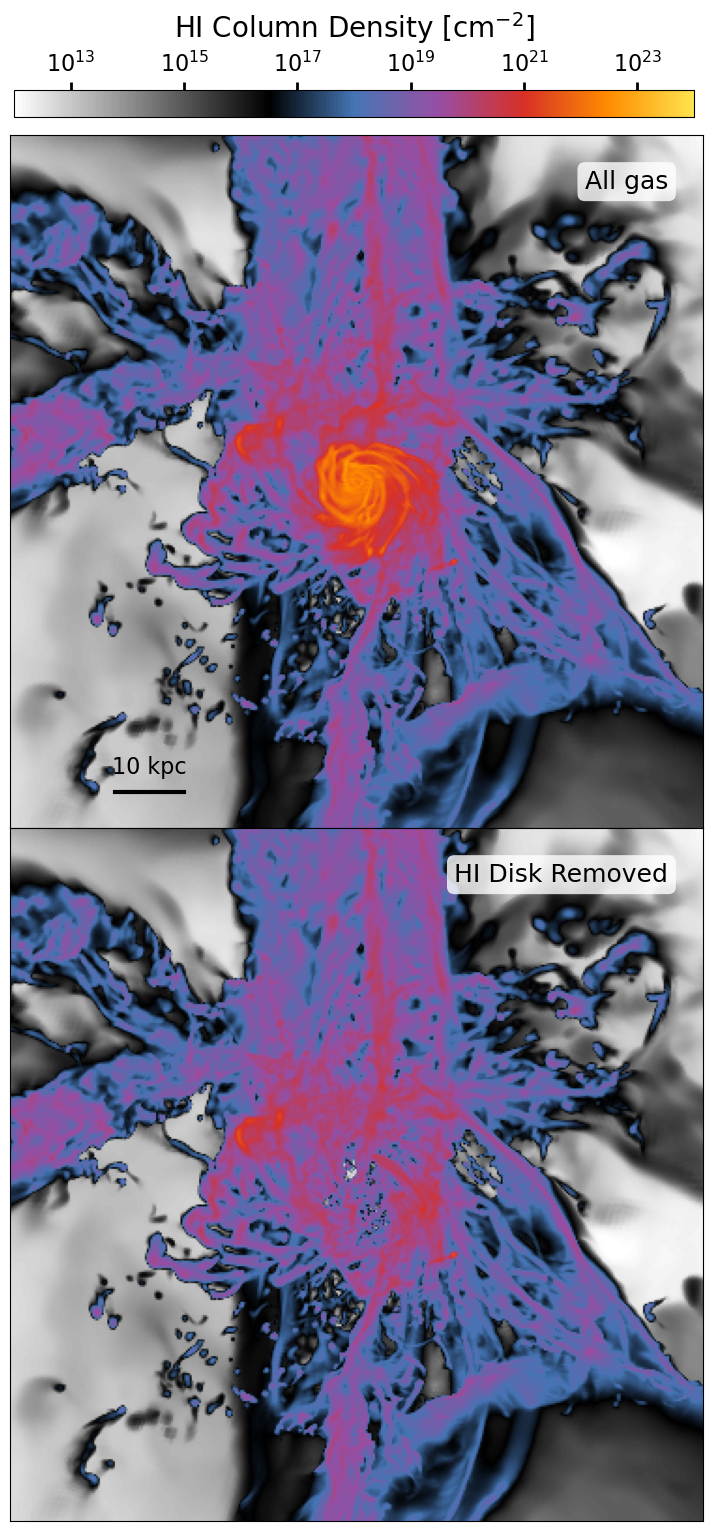

halo: Squall


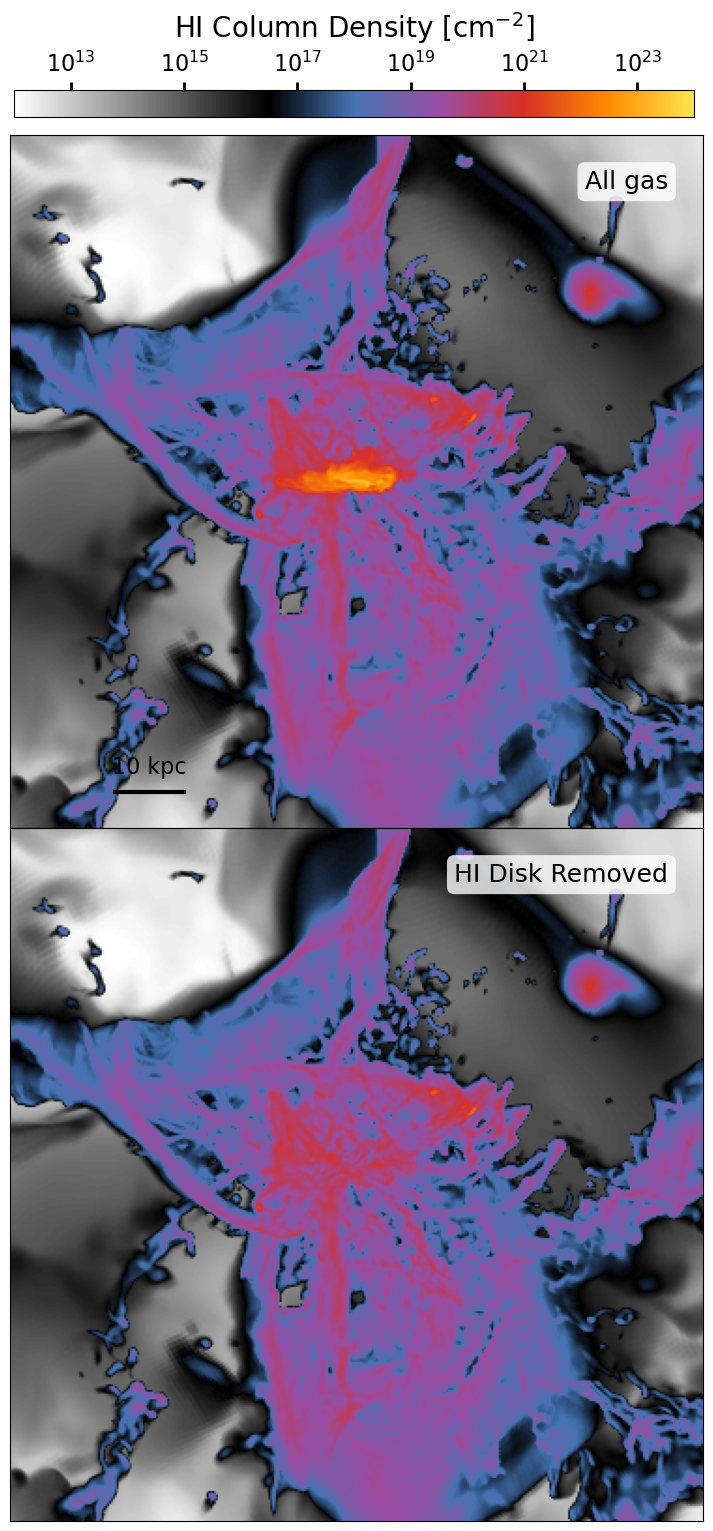

In [12]:
###################################  Figure 1: HI column density with and without disk projection ###################################
#only squal
halos = ['5016']
for orientation in orientations:
    for halo in halos:
        halo_name = halo_dict[halo]
        print('halo:', halo_name)
        foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, output)

        global_vmin = 1e-2
        global_vmax = 1e5

    
        # Use global vmin and vmax for emission maps
        fig, axes = plt.subplots(2, 1, figsize=(10, 18))
        plt.subplots_adjust(wspace=0.0, hspace=0.0)

        region = 'all'
        prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                f'box_{box_name}', 'with_disk', str(resolutions[0]))
        save_path = os.path.join(prefix, 'FRBs')
        file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")
        with h5py.File(file_path, 'r') as f:
            zgroup = list(f.keys())[0]
            group = f[zgroup]

            width_value = group.attrs["image_extent_kpc"]
            round_bin_size_kpc = group.attrs["FRB_pixel_size_kpc"]
            res = int(width_value / round_bin_size_kpc)
            # Plot HI at (0, 0)
            hi_data = group[f"HI_numdensity_{orientation}_{region}"][:]
            ax_hi = axes[0]
            im_hi = ax_hi.imshow(hi_data, origin='lower', cmap=h1_color_map, norm=LogNorm(vmin=h1_proj_min, vmax=h1_proj_max))
            ax_hi.set_xticks([])
            ax_hi.set_yticks([])

            # Compute position and length
            width_value = group.attrs["image_extent_kpc"]  # total physical width of image
            res = int(width_value / round_bin_size_kpc)    # image resolution in pixels
            pixels_per_kpc = res / width_value
            scale_length_pixels = 10 * pixels_per_kpc


            x_start = 0.15 * res  # 5% from left
            y_pos   = 0.05 * res  # 5% from bottom
            x_end   = x_start + scale_length_pixels

            # Draw the scale bar
            ax_hi.plot([x_start, x_end], [y_pos, y_pos], color='black', lw=3)

            # Label the scale bar
            ax_hi.text((x_start + x_end) / 2, y_pos + 0.02 * res, '10 kpc',
                    color='black', fontsize=16, ha='center', va='bottom')
            ax_hi.text(0.95, 0.95, 'All gas', transform=ax_hi.transAxes, fontsize=18, color='k', va='top', ha='right',bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))


            # Add HI colorbar above [0, 0]
            cbar_ax_hi = fig.add_axes([0.17, 0.89, 0.68, 0.015])
            cbar_hi = fig.colorbar(im_hi, cax=cbar_ax_hi, orientation='horizontal')#,shrink=0.9)
            cbar_hi.ax.tick_params(labelsize=16, direction='out')
            cbar_hi.ax.tick_params(width=2,length=6)
            cbar_hi.ax.xaxis.set_label_position('top')
            cbar_hi.ax.xaxis.set_ticks_position('top')
            cbar_hi.set_label('HI Column Density [cm$^{-2}$]', fontsize=20, labelpad=10)

        region = 'cgm'
        prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                f'box_{box_name}', 'without_disk', str(resolutions[0]), 'disk_cgm')
        save_path = os.path.join(prefix, 'FRBs')
        file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")
        with h5py.File(file_path, 'r') as f:
            zgroup = list(f.keys())[0]
            group = f[zgroup]

            width_value = group.attrs["image_extent_kpc"]
            round_bin_size_kpc = group.attrs["FRB_pixel_size_kpc"]
            res = int(width_value / round_bin_size_kpc)
            hi_data = group[f"HI_numdensity_{orientation}_{region}"][:]
            ax_hi = axes[1]
            im_hi = ax_hi.imshow(hi_data, origin='lower', cmap=h1_color_map, norm=LogNorm(vmin=h1_proj_min, vmax=h1_proj_max))
            ax_hi.text(0.95, 0.95, 'HI Disk Removed', transform=ax_hi.transAxes, fontsize=18, color='k', va='top', ha='right',bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))
            ax_hi.set_xticks([])
            ax_hi.set_yticks([])

        output_path = output_dir + '/All_halos/HI_projections'
        os.makedirs(output_path, exist_ok=True)
        output_file = os.path.join(output_path, f'{halo_name}_HI_{orientation}_{snap}.png')
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

Figure 2

In [ ]:
#####################################  Figure 2: all ions emission map with HI contour ###################################

emission_ions = ['HI','OVI', 'CIV', 'SiIV', 'CIII', 'SiIII', 'MgII', 'SiII']
#halos = ['5016']
regions = ['cgm']
orientations = ['face']
for orientation in orientations:
    for region in regions:
        for halo in halos:
            halo_name = halo_dict[halo]
            foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, output)

            if region == 'all':
                prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                      f'box_{box_name}', 'with_disk', str(resolutions[0]))
            elif region == 'cgm':
                prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                      f'box_{box_name}', 'without_disk', str(resolutions[0]), 'disk_cgm')

            save_path = os.path.join(prefix, 'FRBs')
            file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

            global_vmin = 1e-2
            global_vmax = 1e5

            
            with h5py.File(file_path, 'r') as f:
                zgroup = list(f.keys())[0]
                group = f[zgroup]

                width_value = group.attrs["image_extent_kpc"]
                round_bin_size_kpc = group.attrs["FRB_pixel_size_kpc"]
                res = int(width_value / round_bin_size_kpc)


                fig, axes = plt.subplots(4, 2, figsize=(8, 16))
                plt.subplots_adjust(wspace=0.0, hspace=0.0)
                # print('orientation:', orientation)
                # print('region:', region)
                # hi_data = group[f'HI_numdensity_{orientation}_{region}'][:]
                # ax_hi = axes[0, 0]
                # im_hi = ax_hi.imshow(hi_data, origin='lower', cmap=h1_color_map,
                #                         norm=LogNorm(vmin=h1_proj_min, vmax=h1_proj_max))
                # ax_hi.text(0.05, 0.90, 'HI', transform=ax_hi.transAxes, fontsize=16, color='white', weight='bold', va='top', ha='left')
                # ax_hi.set_xticks([])
                # ax_hi.set_yticks([])

                if region == 'cgm':
                    #try:
                    snap_name = foggie_dir + '/' + snap + '/' + snap  
                    ds,refine_box = foggie_load(snap_name, trackfile_name = trackname, halo_c_v_name=halo_c_v_name, do_filter_particles=True, 
                                                disk_relative=True, particle_type_for_angmom='stars', correct_bulk_velocity=True)
                    print('output_dir:', output_dir)
                    disk_file = output_dir + 'plots_halo_00' + halo + '/' + run +  '/FOGGIE' + '/'+ output + '/'+ '/Disk/H1_Disk.h5'
    
                    disk_cut = load_clump(ds, disk_file, source_cut=refine_box)
                    proj_disk = yt.ProjectionPlot(ds, ds.x_unit_disk if orientation == 'edge' else ds.z_unit_disk,
                                                    ('gas', 'H_p0_number_density'),
                                                    center=ds.halo_center_kpc, data_source=disk_cut,
                                                    width=(100, 'kpc'),
                                                    north_vector=ds.z_unit_disk if orientation == 'edge' else ds.x_unit_disk,
                                                    buff_size=[res, res],weight_field=None)
                    disk_frb = proj_disk.frb[('gas', 'H_p0_number_density')].v
                    ax_hi.contour(disk_frb, levels=4, colors='white', linewidths=0.8)
                    # except Exception as e:
                    #     print(f"Could not overlay disk contours on HI: {e}")

                idx = 0
                last_im = None
                for i in range(4):
                    for j in range(2):
                        # if i == 0 and j == 0:
                        #     continue
                        # if idx >= len(emission_ions):
                        #     continue

                        ion = emission_ions[idx]
                        data = group[f"{ion}_emission_{orientation}_{region}"][:]
                        ax = axes[i, j]
                        im = ax.imshow(data, origin='lower', cmap=cmr.flamingo,
                                        norm=LogNorm(vmin=global_vmin, vmax=global_vmax))
                        if ion == 'HI':
                            ax.text(0.05, 0.90, r'H$\alpha$', transform=ax.transAxes, fontsize=16, color='white', weight='bold', va='top', ha='left')
                            
                        elif ion == 'OVI':
                            ax.text(0.05, 0.90, ion, transform=ax.transAxes, fontsize=16, color='white', weight='bold', va='top', ha='left')
                            ax.plot([x_start, x_end], [y_pos, y_pos], color='white', lw=3)
                            ax.text((x_start + x_end) / 2, y_pos + 0.02 * res, '10 kpc',
                    color='white', fontsize=14, ha='center', va='bottom')
                        else:
                            ax.text(0.05, 0.90, ion, transform=ax.transAxes, fontsize=16, color='white', weight='bold', va='top', ha='left')
                        ax.set_xticks([])
                        ax.set_yticks([])

                        if region == 'cgm':
                            
                            try:
                                
                                ax.contour(disk_frb, levels=5, colors='lime', linewidths=0.8)
                            except Exception as e:
                                print(f"Could not overlay disk contours on {ion}: {e}")

                        last_im = im
                        idx += 1

                # cbar_ax_hi = fig.add_axes([0.17, 0.89, 0.3, 0.015])
                # cbar_hi = fig.colorbar(im_hi, cax=cbar_ax_hi, orientation='horizontal', shrink=0.9)
                # cbar_hi.ax.tick_params(labelsize=12, direction='out')
                # cbar_hi.ax.xaxis.set_label_position('top')
                # cbar_hi.ax.xaxis.set_ticks_position('top')
                # cbar_hi.set_label('HI Column Density [cm$^{-2}$]', fontsize=12)

                cbar_ax_em = fig.add_axes([0.25, 0.08, 0.5, 0.015]) #[left, bottom, width, height]
                cbar_em = fig.colorbar(last_im, cax=cbar_ax_em, orientation='horizontal', shrink=0.98)
                cbar_em.ax.tick_params(labelsize=14, direction='out')
                cbar_em.ax.xaxis.set_label_position('bottom')
                cbar_em.ax.xaxis.set_ticks_position('bottom')
                cbar_em.set_label('Surface Brightness \n [photons s$^{-1}$ cm$^{-2}$ sr$^{-1}$]', fontsize=16)

                output_path = output_dir + '/All_halos/emission_projections_grid'
                os.makedirs(output_path, exist_ok=True)
                output_file = os.path.join(output_path, f'{region}_{halo_name}_emission_{orientation}_{snap}.png')
                plt.savefig(output_file, dpi=300, bbox_inches='tight')
                plt.show()
                plt.close()

print("Saved HI and Emission grid plots for both face-on and edge-on.")

In [ ]:
#####################################  Figure 2 - Horizental: all ions emission map with HI contour - Horizontal ###################################

emission_ions = ['HI','OVI', 'CIV', 'SiIV', 'CIII', 'SiIII', 'MgII', 'SiII']

for orientation in orientations:
    for region in regions:
        for halo in halos:
            halo_name = halo_dict[halo]
            foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, output)

            if region == 'all':
                prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                      f'box_{box_name}', 'with_disk', str(resolutions[0]))
            elif region == 'cgm':
                prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                      f'box_{box_name}', 'without_disk', str(resolutions[0]), 'disk_cgm')

            save_path = os.path.join(prefix, 'FRBs')
            file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

            global_vmin = 1e-2
            global_vmax = 1e5

            
            with h5py.File(file_path, 'r') as f:
                zgroup = list(f.keys())[0]
                group = f[zgroup]

                width_value = group.attrs["image_extent_kpc"]
                round_bin_size_kpc = group.attrs["FRB_pixel_size_kpc"]
                res = int(width_value / round_bin_size_kpc)


                fig, axes = plt.subplots(2, 4, figsize=(16, 8))
                plt.subplots_adjust(wspace=0.0, hspace=0.0)
                # print('orientation:', orientation)
                # print('region:', region)
                # hi_data = group[f'HI_numdensity_{orientation}_{region}'][:]
                # ax_hi = axes[0, 0]
                # im_hi = ax_hi.imshow(hi_data, origin='lower', cmap=h1_color_map,
                #                         norm=LogNorm(vmin=h1_proj_min, vmax=h1_proj_max))
                # ax_hi.text(0.05, 0.90, 'HI', transform=ax_hi.transAxes, fontsize=16, color='white', weight='bold', va='top', ha='left')
                # ax_hi.set_xticks([])
                # ax_hi.set_yticks([])

                if region == 'cgm':
                    try:
                        snap_name = foggie_dir + '/' + snap + '/' + snap  
                        ds,refine_box = foggie_load(snap_name, trackname, do_filter_particles=True, halo_c_v_name=halo_c_v_name, disk_relative=True, correct_bulk_velocity=True)
                        print('output_dir:', output_dir)
                        disk_file = output_dir + 'plots_halo_00' + halo + '/' + run +  '/FOGGIE' + '/'+ output + '/'+ '/Disk/H1_Disk.h5'
        
                        disk_cut = load_clump(ds, disk_file, source_cut=refine_box)
                        proj_disk = yt.ProjectionPlot(ds, ds.x_unit_disk if orientation == 'edge' else ds.z_unit_disk,
                                                        ('gas', 'H_p0_number_density'),
                                                        center=ds.halo_center_kpc, data_source=disk_cut,
                                                        width=(100, 'kpc'),
                                                        north_vector=ds.z_unit_disk if orientation == 'edge' else ds.x_unit_disk,
                                                        buff_size=[res, res],weight_field=None)
                        disk_frb = proj_disk.frb[('gas', 'H_p0_number_density')].v
                        ax_hi.contour(disk_frb, levels=4, colors='white', linewidths=0.8)
                    except Exception as e:
                        print(f"Could not overlay disk contours on HI: {e}")

                idx = 0
                last_im = None
                for i in range(2):
                    for j in range(4):
                        # if i == 0 and j == 0:
                        #     continue
                        # if idx >= len(emission_ions):
                        #     continue

                        ion = emission_ions[idx]
                        data = group[f"{ion}_emission_{orientation}_{region}"][:]
                        ax = axes[i, j]
                        im = ax.imshow(data, origin='lower', cmap=cmr.flamingo,
                                        norm=LogNorm(vmin=global_vmin, vmax=global_vmax))
                        if ion == 'HI':
                            ax.text(0.05, 0.90, r'H$\alpha$', transform=ax.transAxes, fontsize=16, color='white', weight='bold', va='top', ha='left')
                        else:
                            ax.text(0.05, 0.90, ion, transform=ax.transAxes, fontsize=16, color='white', weight='bold', va='top', ha='left')
                        ax.set_xticks([])
                        ax.set_yticks([])

                        if region == 'cgm':
                            
                            try:
                                
                                ax.contour(disk_frb, levels=5, colors='lime', linewidths=0.8)
                            except Exception as e:
                                print(f"Could not overlay disk contours on {ion}: {e}")

                        last_im = im
                        idx += 1

                # cbar_ax_hi = fig.add_axes([0.17, 0.89, 0.3, 0.015])
                # cbar_hi = fig.colorbar(im_hi, cax=cbar_ax_hi, orientation='horizontal', shrink=0.9)
                # cbar_hi.ax.tick_params(labelsize=12, direction='out')
                # cbar_hi.ax.xaxis.set_label_position('top')
                # cbar_hi.ax.xaxis.set_ticks_position('top')
                # cbar_hi.set_label('HI Column Density [cm$^{-2}$]', fontsize=12)

                cbar_ax_em = fig.add_axes([0.25, 0.08, 0.5, 0.015]) #[left, bottom, width, height]
                cbar_em = fig.colorbar(last_im, cax=cbar_ax_em, orientation='horizontal', shrink=0.9)
                cbar_em.ax.tick_params(labelsize=12, direction='out')
                cbar_em.ax.xaxis.set_label_position('bottom')
                cbar_em.ax.xaxis.set_ticks_position('bottom')
                cbar_em.set_label('Surface Brightness \n [photons s$^{-1}$ cm$^{-2}$ sr$^{-1}$]', fontsize=12)

                output_path = output_dir + '/All_halos/emission_projections_grid'
                os.makedirs(output_path, exist_ok=True)
                output_file = os.path.join(output_path, f'vertical_{region}_{halo_name}_emission_{orientation}_{snap}.png')
                plt.savefig(output_file, dpi=300, bbox_inches='tight')
                plt.show()
                plt.close()

print("Saved HI and Emission grid plots for both face-on and edge-on.")

Figure 3

orientation: face


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_63839/1636725003.py:110: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(profiles, axis=0)


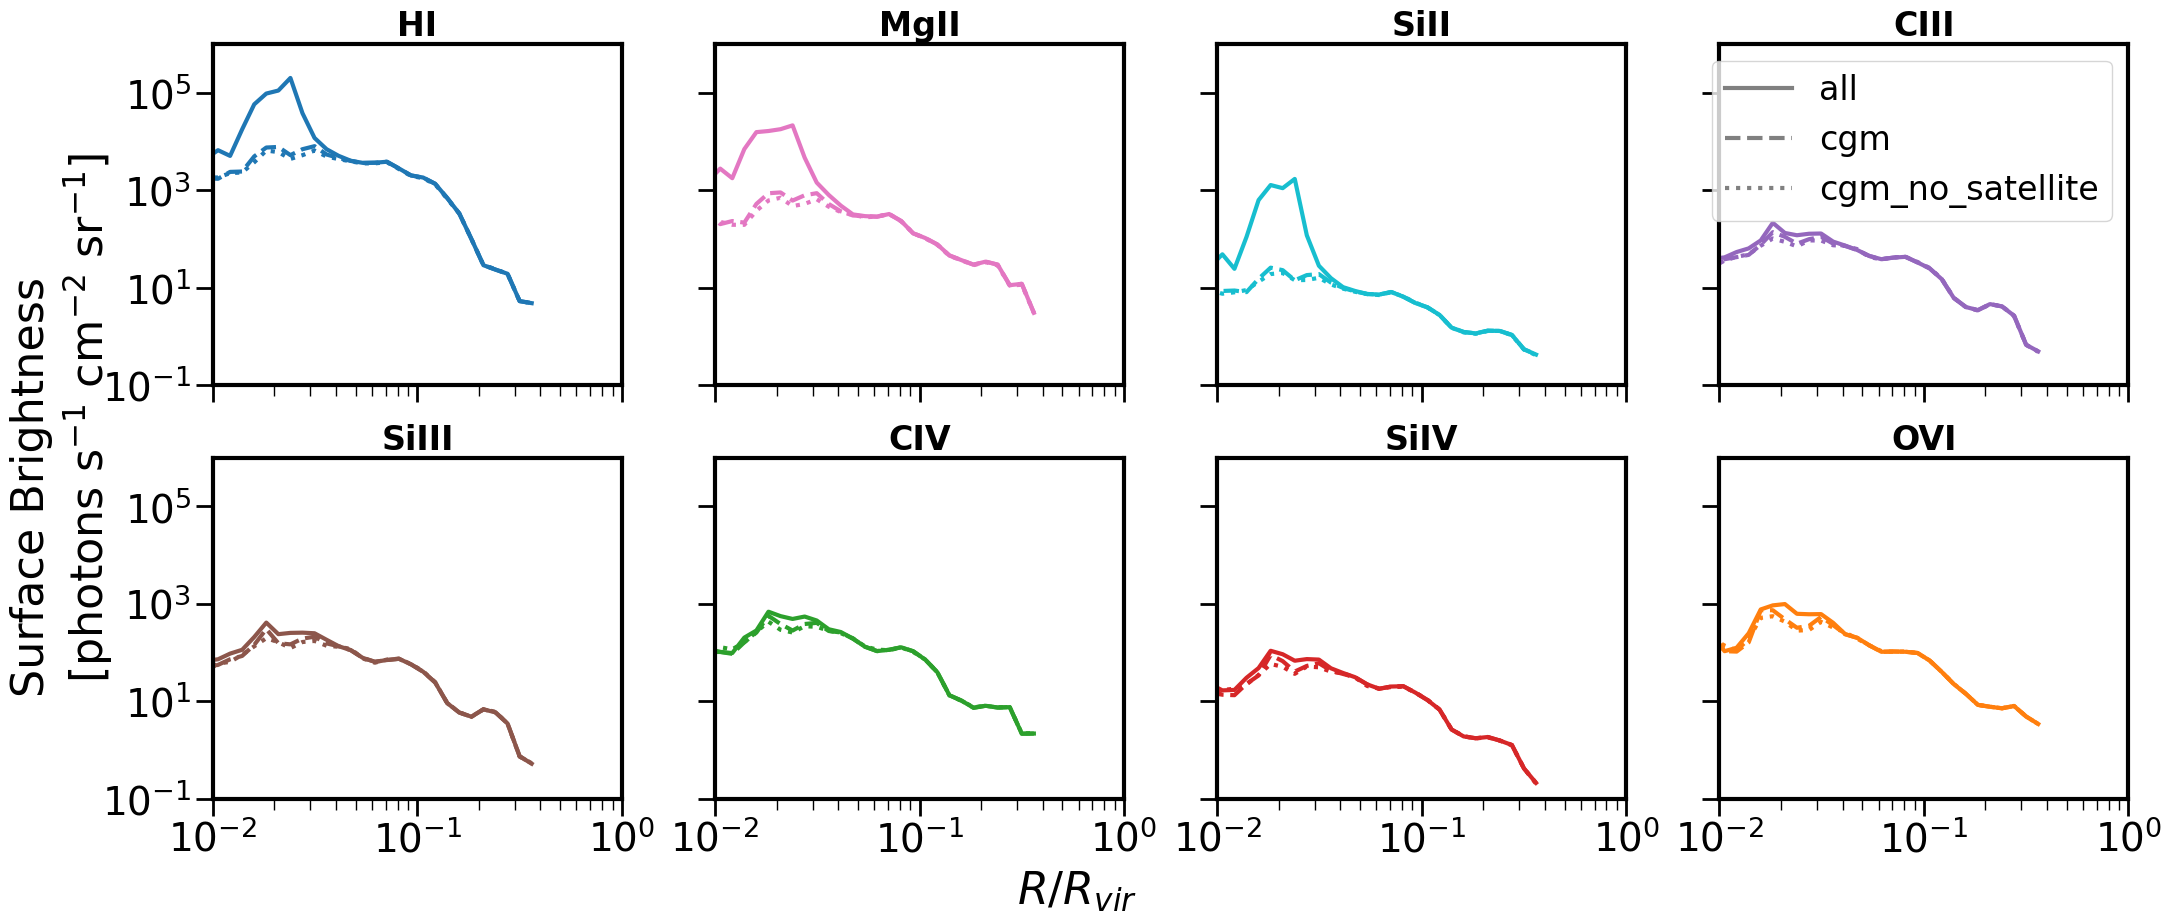

orientation: edge


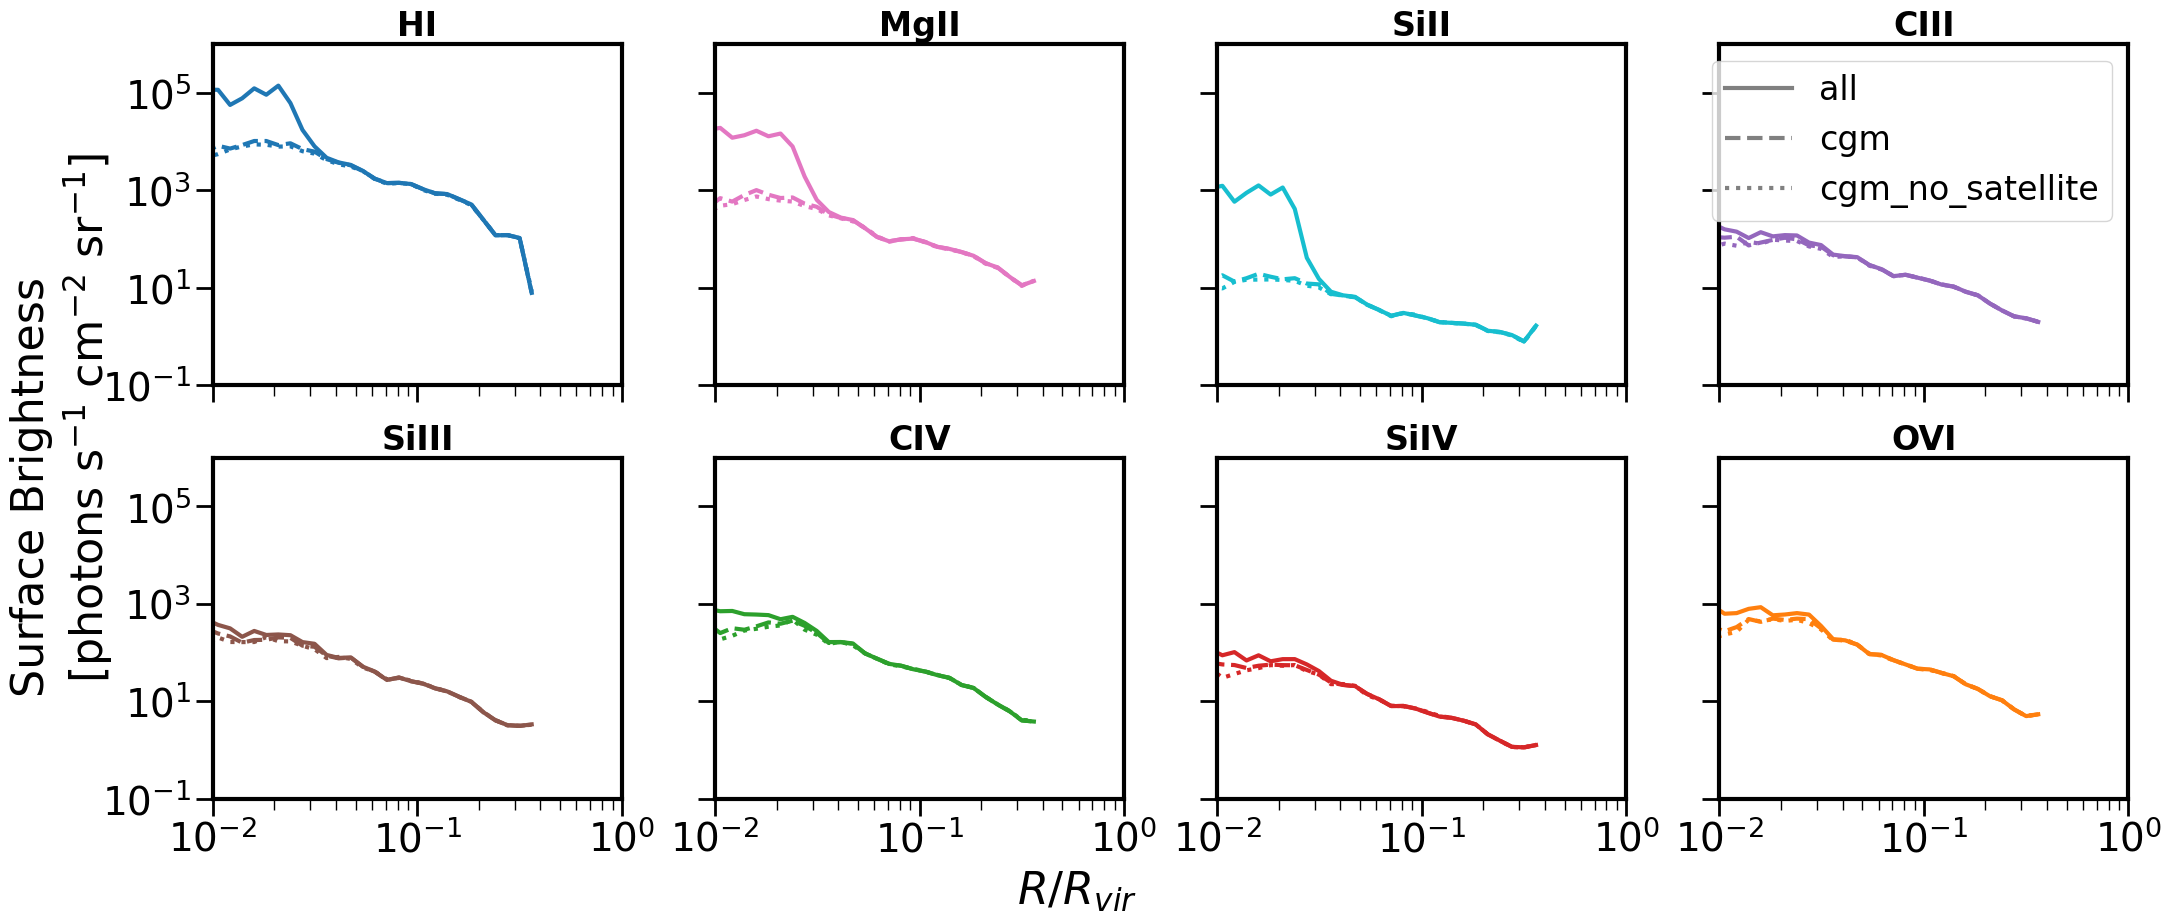

In [26]:

# Settings
ions = ['HI', 'MgII', 'SiII','CIII', 'SiIII','CIV', 'SiIV','OVI'] 
ion_color_dict = {
    'HI': '#1f77b4', 'OVI': '#ff7f0e', 'CIV': '#2ca02c', 'SiIV': '#d62728',
    'CIII': '#9467bd', 'SiIII': '#8c564b', 'MgII': '#e377c2', 'SiII': '#17becf'
}
orientations = ['face', 'edge']
halos = ['2878']#,'2392','5016','5036','8508']
r_bins = np.logspace(np.log10(0.5), 2.0, 40)
r_centers = 0.5 * (r_bins[1:] + r_bins[:-1])
font_title = 24
font_label = 32
font_tick = 28
font_legend = 24
z = 0.5  # target redshift
resolutions = [0.27]
resolution = resolutions[0]
regions = ['all', 'cgm','cgm_no_satellite']

# Container for all profiles
all_profiles = {region: {ori: {ion: [] for ion in ions} for ori in orientations} for region in regions}

for region in regions:
    for halo in halos:
        halo_name = halo_dict[halo]
        for orientation in orientations:
            for ion in ions:
                # Get Rvir
                halo_infor_path = '/Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/' + f'/halo_infos/00{halo}/{run}' 
                rvir_masses_file = os.path.join(halo_infor_path, "rvir_masses.hdf5")
                with h5py.File(rvir_masses_file, 'r') as f:
                    data = f['all_data'][:]
                    idx = np.argmin(np.abs(data['redshift'] - z))
                    rvir = data['radius'][idx]

                if region == 'all':
                    prefix = os.path.join(
                        output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                        f'box_{box_name}', 'with_disk', str(resolution)
                    )
                elif region == 'cgm':
                    prefix = os.path.join(
                        output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                        f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm'
                    )
                elif region == 'cgm_no_satellite':
                    if halo == '4123':
                        prefix = os.path.join(
                        output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                        f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm'
                    )
                    else:
                        prefix = os.path.join(
                            output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                            f'box_{box_name}', 'no_satellite', str(resolution)
                        )

                file_path = os.path.join(prefix, 'FRBs', f"{halo_name}_emission_maps.hdf5")
                if not os.path.exists(file_path):
                    continue

                with h5py.File(file_path, 'r') as f:
                    x = np.array(f[f'z={z}/{ion}_x_{orientation}_{region}'])
                    y = np.array(f[f'z={z}/{ion}_y_{orientation}_{region}'])
                    emission = np.array(f[f'z={z}/{ion}_emission_{orientation}_{region}']).flatten()

                xx, yy = np.meshgrid(x, y)
                radius = np.sqrt(xx**2 + yy**2).flatten()
                mask = emission > 1e-1
                radius = radius[mask]
                emission = emission[mask]

                profile = np.full(len(r_centers), np.nan)
                for i in range(len(r_centers)):
                    in_bin = (radius >= r_bins[i]) & (radius < r_bins[i+1])
                    if np.any(in_bin):
                        profile[i] = np.median(emission[in_bin])

                all_profiles[region][orientation][ion].append((profile, rvir))

# Plotting
for orientation in orientations:
    print('orientation:', orientation)
    fig, axs = plt.subplots(2, 4, figsize=(22, 10), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.0001, hspace=0.01)
    axs = axs.flatten()

    for ion_idx, ion in enumerate(ions):
        ax = axs[ion_idx]
        color = ion_color_dict[ion]

        for spine in ax.spines.values():
            spine.set_linewidth(3)
            spine.set_edgecolor('black')

        for region, linestyle, hatch, alpha in [
            ('all', '-', None, 0.3),
            ('cgm', '--', '///', 0.15),
            ('cgm_no_satellite', ':', 'xxx', 0.15)
        ]:
        
            # Normalize profiles by Rvir
            profiles = []
            for prof, rvir in all_profiles[region][orientation][ion]:
                profiles.append(prof)  # normalize by rvir

            profiles = np.array(profiles)
            if profiles.shape[0] == 0:
                continue
            median = np.nanmedian(profiles, axis=0)
            p16 = np.nanpercentile(profiles, 16, axis=0)
            p84 = np.nanpercentile(profiles, 84, axis=0)

            ax.plot(r_centers / rvir, median, lw=3, color=color, linestyle=linestyle, label=f'{region}')
            ax.fill_between(r_centers / rvir, p16, p84, facecolor=color, alpha=alpha,
                            hatch=hatch, edgecolor=color if hatch else None, linewidth=0.0)

        #ax.set_title(r'H$\mathrm{I}$' if ion == 'HI' else ion, fontsize=font_title, fontweight='bold')
        ax.set_title(ion, fontsize=font_title, fontweight='bold')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(1e-2, 1)
        ax.set_ylim(1e-1, 1e6)
        ax.tick_params(labelsize=font_tick)
        ax.tick_params(labelsize=font_tick, length=12, width=2, direction='out', which='major')
        ax.tick_params(length=8, width=1, direction='out', which='minor')

        legend_handles = [ Line2D([0], [0], color='grey', lw=3, linestyle='-', label='all'),
                        Line2D([0], [0], color='grey', lw=3, linestyle='--', label='cgm'),
                        Line2D([0], [0], color='grey', lw=3, linestyle=':', label='cgm_no_satellite')]

        if ion == 'CIII':
            ax.legend(legend_handles, labels, loc='upper right', ncol=1, fontsize=font_legend)

    fig.text(0.5, 0.02, '$R/R_{vir}$', ha='center', fontsize=font_label)
    fig.text(0.015, 0.5, 'Surface Brightness \n [photons s$^{-1}$ cm$^{-2}$ sr$^{-1}$]', va='center',
             rotation='vertical', fontsize=font_label)

    handles, labels = axs[0].get_legend_handles_labels()
    #fig.legend(handles, labels, loc='lower right', ncol=4, fontsize=font_legend)

    plt.tight_layout(rect=[0.05, 0.05, 1, 0.93])
    save_dir = os.path.join(output_dir, 'All_halos', 'emission_profiles')
    os.makedirs(save_dir, exist_ok=True)
    save_name = f"all&cgm_allhalos_{orientation}_{resolution}_median_profiles_allhalo.png"
    #plt.savefig(os.path.join(save_dir, save_name), dpi=400)
    plt.show()
    plt.close()


Figure 4

In [ ]:
#emission_ions = ['HI','OVI', 'CIV', 'SiIV', 'CIII', 'SiIII', 'MgII', 'SiII']#, 'CII']
emission_ions = ['OVI','CIII','MgII']
resolutions = [0.27,1,3,6]
ion_temperatures = {
    'OVI': r'T $\sim$ 5 × 10$^5$ K',
    'CIII': r'T $\sim$ 5 × 10$^4$ K',
    'MgII': r'T $\sim$ 10$^4$ K'
}
resolution_labels = {0.27: '0.27 kpc', 1: '1 kpc', 3: '3 kpc', 6: '6 kpc'}
halos = {'4123'}
orientations = ['edge']

for region in regions:
    print(region)
    for halo in halos:
        halo_name = halo_dict[halo]
        print('halo:', halo_name)
        for orientation in orientations:  # 'edge' or 'face'
            print('orientation:', orientation)
            #fig, axes = plt.subplots(len(emission_ions), len(resolutions), figsize=(4*len(resolutions), 3*len(emission_ions)))
            fig, axes = plt.subplots(len(emission_ions), len(resolutions),
                         figsize=(3*len(resolutions), 3*len(emission_ions)),
                         gridspec_kw={'wspace': 0, 'hspace': 0.05})
            
            plt.subplots_adjust(wspace=0, hspace=0.05)
            axes = np.array(axes)  # Ensure 2D array even if 1 row or 1 column
            last_im = None

            for col, resolution in enumerate(resolutions):
                for row, ion in enumerate(emission_ions):
                    
                    foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, output)

                    if region == 'all':
                        prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                            f'box_{box_name}', 'with_disk', str(resolution))
                    elif region == 'cgm':
                        prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                                            f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm')

                    save_path = os.path.join(prefix, 'FRBs')
                    file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")
                    if not os.path.isfile(file_path):
                        print(f"Missing file: {file_path}")
                        continue

                    with h5py.File(file_path, 'r') as f:
                        zgroup = list(f.keys())[0]
                        group = f[zgroup]

                        global_vmin = 1e0
                        global_vmax = 4000
                        data = group[f"{ion}_emission_{orientation}_{region}"][:]


                    cmap1 = cmr.take_cmap_colors('cmr.viola_r', 3, cmap_range=(0.2, 0.25), return_fmt='rgba')       # >10,000
                    cmap2 = cmr.take_cmap_colors('autumn', 2, cmap_range=(0.8, 0.9), return_fmt='rgba')    # >1000
                    cmap3 = cmr.take_cmap_colors('cool', 4, cmap_range=(0.1, 0.2), return_fmt='rgba')       # >100
                    cmap4 = cmr.take_cmap_colors('cmr.neutral_r', 11, cmap_range=(0.0, 0.5), return_fmt='rgba')    # background

                    cmap = np.hstack([cmap4, cmap3, cmap1,cmap2]) #cmap2, cmap1])
                    mymap = mcolors.LinearSegmentedColormap.from_list('cmap', cmap)

                    if region == 'cgm':
                        try:
                            snap_name = foggie_dir + '/' + snap + '/' + snap  
                            ds,refine_box = foggie_load(snap_name, trackfile_name = trackname, halo_c_v_name=halo_c_v_name, do_filter_particles=True, 
                                                disk_relative=True, particle_type_for_angmom='stars', correct_bulk_velocity=True)
                            print('output_dir:', output_dir)
                            disk_file = output_dir + 'plots_halo_00' + halo + '/' + run +  '/FOGGIE' + '/'+ output + '/'+ '/Disk/H1_Disk.h5'
            
                            disk_cut = load_clump(ds, disk_file, source_cut=refine_box)
                            proj_disk = yt.ProjectionPlot(ds, ds.x_unit_disk if orientation == 'edge' else ds.z_unit_disk,
                                                            ('gas', 'H_p0_number_density'),
                                                            center=ds.halo_center_kpc, data_source=disk_cut,
                                                            width=(100, 'kpc'),
                                                            north_vector=ds.z_unit_disk if orientation == 'edge' else ds.x_unit_disk,
                                                            buff_size=[res, res],weight_field=None)
                            disk_frb = proj_disk.frb[('gas', 'H_p0_number_density')].v
                            ax_hi.contour(disk_frb, levels=4, colors='white', linewidths=0.8)
                        except Exception as e:
                            print(f"Could not overlay disk contours on HI: {e}")


                    ax = axes[row, col]
                    im = ax.imshow(data, origin='lower', cmap=mymap, norm=LogNorm(vmin=global_vmin, vmax=global_vmax))
                    last_im = im

                    # Add ion name to the first column (left side)
                    if col == 0:
                        if ion == 'HI':
                            ax.text(0.05, 0.90, r'H$\alpha$', transform=ax.transAxes, fontsize=14,
                                color='k', weight='bold', va='top', ha='left')
                        else:
                            ax.text(0.05, 0.90, ion, transform=ax.transAxes, fontsize=14,
                                color='k', weight='bold', va='top', ha='left')
                            
                        temp_label = ion_temperatures.get(ion, "")
                        ax.text(-0.05, 0.5, temp_label,
                                transform=ax.transAxes,
                                fontsize=14,
                                color='k',
                                ha='right',
                                va='center',
                                rotation='vertical')
                    if row == 0:
                        ax.set_title(resolution_labels[resolution],
                                    fontsize=14, color='k', pad=8)
                        
                    if (row == 0) and (col == 0):
                         ax.plot([x_start, x_end], [y_pos, y_pos], color='black', lw=3)
                         ax.text((x_start + x_end) / 2, y_pos + 0.02 * res, '10 kpc',color='black', fontsize=12, ha='center', va='bottom')



                    # Add resolution title to the top row
                    # if row == 0:
                    #     ax.set_title(f"{resolution} kpc", fontsize=14, color='k')

                    # if col == 0 and row == 0:
                    #     bar_length_pix = int(10 / 0.27)
                    #     x_start = data.shape[1] - bar_length_pix - 30  # Shifted left
                    #     y_start = 10

                    #     ax.plot([x_start, x_start + bar_length_pix], [y_start, y_start],
                    #             color='k', lw=2, transform=ax.transData, clip_on=False)

                    #     ax.text(x_start + bar_length_pix / 2, y_start + 5, '10 kpc',
                    #             color='k', fontsize=12, ha='center', va='bottom',
                    #             transform=ax.transData, clip_on=False)

                    # Remove ticks
                    ax.set_xticks([])
                    ax.set_yticks([])

                    # if region == 'cgm':    
                    #         try:
                                
                    #             ax.contour(disk_frb, levels=5, colors='lime', linewidths=0.8)
                    #         except Exception as e:
                    #             print(f"Could not overlay disk contours on {ion}: {e}")


            # Colorbar
            # Add horizontal colorbar below the full figure
            cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.015])  # [left, bottom, width, height]
            cbar = fig.colorbar(last_im, cax=cbar_ax, orientation='horizontal')

            # Set label and ticks appearance
            cbar.set_label('Surface Brightness [photons s$^{-1}$ cm$^{-2}$ sr$^{-1}$]', fontsize=16, labelpad=1)
            cbar.ax.tick_params(labelsize=14, length=8, width=1.5, direction='out',which='major')
            cbar.ax.tick_params(labelsize=14, length=4, width=1.5, direction='out',which='minor')


            output_path = output_dir + '/All_halos/spatialres_emission_sensitivity_projections'
            os.makedirs(output_path, exist_ok=True)
            output_file = os.path.join(output_path, f'{region}_{halo_name}_spatialres_emission_{orientation}_{snap}.png')
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()


Appendix Figure 5

In [ ]:
#####################################  Appendix Figure 5: mass fraction heat maps for all ions and spatial and spectral resolutions ###################################

def stretch_colormap(cmap, mid_value=0.2, mid_compress=0.5):
    """Create a new colormap that stretches colors near the low end."""
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    N = 256  # resolution of the colormap

    # Stretching function
    below = 0.58#0.7
    above = 0.4#0.4
    def scale(x):
        if x < mid_value:
            return below * (x / mid_value)  # Stretch 0–mid_value into 0–0.5
        else:
            return below + above * ((x - mid_value) / (1 - mid_value))  # Compress mid_value–1 into 0.5–1

    # Build new color mapping
    for i in range(N):
        old_idx = i / (N-1)
        new_idx = scale(old_idx)
        r, g, b, a = cmap(new_idx)
        cdict['red'].append((old_idx, r, r))
        cdict['green'].append((old_idx, g, g))
        cdict['blue'].append((old_idx, b, b))
        cdict['alpha'].append((old_idx, a, a))

    new_cmap = colors.LinearSegmentedColormap('stretched_cmap', cdict)
    return new_cmap



# Create a single color scale
vmin = 0
vmax = 100
cmap = cmr.get_sub_cmap('inferno_r', 0.0, 1)
stretched_cmap = stretch_colormap(cmap, mid_value=0.2)


for region in regions:
    
    for orientation in orientations:
        print('region:', region, 'orientation:', orientation)
        fig, axs = plt.subplots(2, 4, figsize=(22, 10), sharex=True, sharey=True)
        axs = axs.flatten()
        all_heatmaps = []
        for ion_idx, ion in enumerate(ions):
            ax = axs[ion_idx]
            heatmap_array = np.zeros((len(flux_thresholds[ion]), len(resolutions)))

            for res_idx, resolution in enumerate(resolutions):
                all_fractions_per_thresh = []

                for halo in halos:
                    halo_name = halo_dict[halo]
                    foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)

                    if region == 'all':
                        prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'with_disk', str(resolution))
                    elif region == 'cgm':
                        prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm')

                    save_path = os.path.join(prefix, 'FRBs')
                    file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

                    with h5py.File(file_path, 'r') as f:
                        mass_data = np.array(f[f'z={z}/{ion}_mass_{orientation}_{region}']).flatten()
                        emission_data = np.array(f[f'z={z}/{ion}_emission_{orientation}_{region}']).flatten()

                    total_mass = mass_data.sum()
                    halo_fractions = []
                    for thresh in flux_thresholds[ion]:
                        above_id = np.where(emission_data >= thresh)
                        mass_above = mass_data[above_id].sum()
                        frac = (mass_above / total_mass) * 100
                        halo_fractions.append(frac)

                    all_fractions_per_thresh.append(halo_fractions)

                # Compute mean across halos, store in column for that resolution
                mean_fractions = np.mean(all_fractions_per_thresh, axis=0)
                for t_idx, frac in enumerate(mean_fractions):
                    heatmap_array[t_idx, res_idx] = frac

            # Flip and annotate
            flipped_array = np.flipud(heatmap_array)
            annotations = np.round(flipped_array, 1)

            # Save for shared colorbar setup
            im = sns.heatmap(
                flipped_array,
                annot=annotations,
                fmt=".0f",
                annot_kws={"size": 22},
                ax=ax,
                xticklabels=resolutions,
                yticklabels=flux_thresholds[ion][::-1],
                vmin=vmin,
                vmax=vmax,
                cmap=stretched_cmap,
                cbar=False  # Disable individual colorbars
                #norm=norm
            )

            # if ion_idx == 0 or ion_idx == 4:
            #     ax.set_ylabel('Sensityvity limit [photons s$^{-1}$ cm$^{-2}$ sr$^{-1}$]', fontsize=15)
            # else:
            #     ax.set_ylabel('')

            # Set x-labels only on the bottom row (row 1, i.e., ion_idx >= 4)
            # if ion_idx >= 4:
            #     ax.set_xlabel('Spatial Resolution (kpc)', fontsize=15)
            # else:
            #     ax.set_xlabel('')
            if ion == 'HI':
                ax.set_title(r'H$\alpha$', fontsize=16, fontweight='bold')
            else:
                ax.set_title(ion, fontsize=24, fontweight='bold')
            ax.tick_params(axis='both', labelsize=20, length=6, width=2)
            ax.tick_params(axis='y', labelrotation=0)


            all_heatmaps.append(im)

        # Shared colorbar (based on last heatmap object)
        cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
        cbar = fig.colorbar(all_heatmaps[-1].collections[0], cax=cbar_ax)
        cbar.set_label('Observable Mass Fraction (%)', fontsize=20)
        cbar.ax.tick_params(labelsize=18)

        # Final layout
        # Adjust layout before adding shared labels
        plt.tight_layout(rect=[0.05, 0.05, 0.88, 0.95])  # Leave room on left for y-label and right for colorbar

        # Shared x and y labels
        fig.text(0.5, 0.02, 'Spatial Resolution (kpc)', ha='center', fontsize=24)
        fig.text(0.035, 0.5, 'Sensitivity Limit [photons s$^{-1}$ cm$^{-2}$ sr$^{-1}$]', va='center', rotation='vertical', fontsize=24)

        output_path = output_dir + '/All_halos/Mass_fraction_heatmaps'
        os.makedirs(output_path, exist_ok=True)
        output_file = os.path.join(output_path, f'{region}_allhalosave_massfraction_{orientation}_{snap}.png')
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()


Figure 6

In [8]:
import os, re, difflib
import numpy as np
import h5py
from scipy.optimize import curve_fit

# --- Choose which panel to fit ---
FIT_ION = 'MgII'         # e.g. 'HI','OVI','CIV','SiIII',...
FIT_REGION = 'cgm'      # 'all' or 'cgm'
FIT_ORIENTATION = 'edge'  # 'face' or 'edge'

def best_match(name, candidates, cutoff=0.6):
    """Return best fuzzy match from candidates or None."""
    matches = difflib.get_close_matches(name, candidates, n=1, cutoff=cutoff)
    return matches[0] if matches else None

def find_z_group(f, z_str):
    """Find the z= group. Try exact, else fuzzy match on numeric value."""
    # exact first
    if f"z={z_str}" in f:
        return f"z={z_str}"
    # otherwise try numeric match among groups that look like z=...
    z_groups = [k for k in f.keys() if isinstance(k, str) and k.startswith("z=")]
    if not z_groups:
        return None
    # pick the group whose numeric value is closest to requested z
    try:
        target = float(z_str)
        vals = []
        for g in z_groups:
            try:
                vals.append((abs(float(g.split('=')[1]) - target), g))
            except Exception:
                pass
        if vals:
            vals.sort()
            return vals[0][1]
    except Exception:
        pass
    # otherwise just return the closest string match
    return best_match(f"z={z_str}", z_groups, cutoff=0.0)

def find_dataset_paths(f, zgrp, ion, orientation, region):
    """
    Try to locate the mass and emission datasets with fuzzy matching
    based on expected pattern: '{ion}_mass_{orientation}_{region}'
    and '{ion}_emission_{orientation}_{region}' under the z-group.
    """
    if zgrp not in f:
        return None, None
    grp = f[zgrp]

    keys = list(grp.keys())
    if len(keys) == 0:
        return None, None

    # Build target tokens; allow small variations in naming
    # Try multiple orientation tokens
    orientation_alts = [orientation, 
                        'edgeon' if orientation == 'edge' else 'faceon', 
                        'edge_on' if orientation == 'edge' else 'face_on']
    region_alts = [region, 'disk_cgm' if region == 'cgm' else region]

    # ion variations (e.g., "O VI" vs "OVI")
    ion_alts = [ion, ion.replace(' ', ''), ion.replace(' ', '_')]
    # also common LaTeX-like replacements (optional)
    ion_alts += [ion.replace('VI', 'VI').replace(' ', ''), ion.upper()]

    # try exact pattern first, then fuzzy
    candidates = keys

    def pattern_for(i_tok, o_tok, r_tok, kind):
        # kind: 'mass' or 'emission'
        return f"{i_tok}_{kind}_{o_tok}_{r_tok}"

    best_mass, best_em = None, None
    for i_tok in ion_alts:
        for o_tok in orientation_alts:
            for r_tok in region_alts:
                exact_mass = pattern_for(i_tok, o_tok, r_tok, 'mass')
                exact_em   = pattern_for(i_tok, o_tok, r_tok, 'emission')
                if exact_mass in grp and exact_em in grp:
                    return f"{zgrp}/{exact_mass}", f"{zgrp}/{exact_em}"

    # fuzzy fallback: among keys in z-group, pick best mass/emission that contain the tokens
    target_mass = pattern_for(ion, orientation, region, 'mass')
    target_em   = pattern_for(ion, orientation, region, 'emission')
    k_mass = best_match(target_mass, candidates, cutoff=0.0)
    k_em   = best_match(target_em, candidates, cutoff=0.0)
    if k_mass is not None and k_em is not None:
        return f"{zgrp}/{k_mass}", f"{zgrp}/{k_em}"
    return None, None

def compute_mass_fraction_grid(ion, region, orientation):
    """
    Recompute the heatmap data (no plotting): returns
      xs: np.array of spatial resolutions [kpc], shape (Nx,)
      ys: np.array of sensitivity thresholds [photons cm^-2 s^-1 sr^-1], shape (Ny,)
      Z:  np.array mass fraction [%], shape (Ny, Nx), rows correspond to ys ascending
    Skips halos that lack the needed datasets (warns once per halo).
    """
    xs = np.array(resolutions, dtype=float)
    ys = np.array(flux_thresholds[ion], dtype=float)  # ascending order

    Z = np.zeros((len(ys), len(xs)), dtype=float)

    for j, xres in enumerate(resolutions):
        per_halo = []
        for halo in halos:
            halo_name = halo_dict[halo]
            foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)

            if region == 'all':
                prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', snap, f'box_{box_name}', 'with_disk', str(xres))
            elif region == 'cgm':
                prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', snap, f'box_{box_name}', 'without_disk', str(xres), 'disk_cgm')
            else:
                raise ValueError("region must be 'all' or 'cgm'")

            file_path = os.path.join(prefix, 'FRBs', f"{halo_name}_emission_maps.hdf5")
            if not os.path.isfile(file_path):
                print(f"[warn] Missing file for halo {halo}: {file_path}")
                continue

            try:
                with h5py.File(file_path, 'r') as f:
                    # find z-group robustly
                    zgrp = find_z_group(f, z)
                    if zgrp is None:
                        print(f"[warn] No z-group like 'z={z}' in {file_path}. Available: {list(f.keys())}")
                        continue

                    mass_path, em_path = find_dataset_paths(f, zgrp, ion, orientation, region)
                    if mass_path is None or em_path is None:
                        print(f"[warn] Could not find datasets for ({ion},{orientation},{region}) in {file_path} under {zgrp}. Keys: {list(f[zgrp].keys())[:10]}...")
                        continue

                    mass_data = np.array(f[mass_path], dtype=float).ravel()
                    emission_data = np.array(f[em_path], dtype=float).ravel()
            except Exception as e:
                print(f"[warn] Failed reading {file_path}: {e}")
                continue

            total_mass = mass_data.sum()
            if not np.isfinite(total_mass) or total_mass <= 0:
                print(f"[warn] Non-positive/invalid total mass for halo {halo} at res {xres}")
                continue

            halo_fracs = []
            for thresh in ys:
                above = emission_data >= thresh
                frac = (mass_data[above].sum() / total_mass) * 100.0
                halo_fracs.append(frac)
            per_halo.append(halo_fracs)

        if len(per_halo) == 0:
            # if absolutely nothing available, fill NaNs so fit can skip later
            Z[:, j] = np.nan
        else:
            Z[:, j] = np.nanmean(np.asarray(per_halo, dtype=float), axis=0)

    return xs, ys, Z

# --- Fit a simple power-law model: f = a * x^b * y^c + d ---
def powerlaw_model(X, a, b, c, d):
    x, y = X
    return a * (x**b) * (y**c) + d




In [9]:
# --- Power-law fit with d fixed to 0:  f(x,y) = a * x^b * y^c ----------------------------
import numpy as np
from scipy.optimize import curve_fit

# 1) Build grid (re-uses your function and config)
xs, ys, Z = compute_mass_fraction_grid(FIT_ION, FIT_REGION, FIT_ORIENTATION)  # Z: (Ny,Nx)

# 2) Mesh + flatten to matched samples; mask NaNs
XX, YY = np.meshgrid(xs, ys)   # shapes (Ny, Nx)
x = XX.ravel().astype(float)
y = YY.ravel().astype(float)
z = Z.ravel().astype(float)

mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x, y, z = x[mask], y[mask], z[mask]

# If nothing valid, bail early
if len(z) == 0:
    raise RuntimeError("No valid data to fit after filtering. Check upstream data paths.")

# 3) Define model with d=0
def powerlaw_n0(X, a, b, c):
    x, y = X
    return a * (x**b) * (y**c)

# 4) Use log–log linear regression for robust initial guesses
#    log z = log a + b log x + c log y
eps = 1e-8
mask_pos = z > eps
if np.count_nonzero(mask_pos) < 3:
    # fallback: crude seeds if too few positive points for log fit
    a0 = max(1.0, float(np.nanmean(z)))
    b0, c0 = -0.1, -0.3
else:
    Xlog = np.vstack([np.log10(x[mask_pos] + eps), np.log10(y[mask_pos] + eps)]).T
    zlog = np.log10(z[mask_pos] + eps)
    # solve least-squares for [b, c] and intercept
    # augment with ones for intercept
    Xaug = np.column_stack([Xlog, np.ones(len(Xlog))])
    coef, *_ = np.linalg.lstsq(Xaug, zlog, rcond=None)
    b0, c0, intercept = coef
    a0 = 10.0**intercept
# Reasonable bounds
p0 = [a0, b0, c0]
lower = [0.0, -10.0, -10.0]
upper = [1e6,  10.0,  10.0]

# 5) Fit
popt, pcov = curve_fit(powerlaw_n0, (x, y), z, p0=p0, bounds=(lower, upper), maxfev=500000)
a, b, c = popt

# 6) Diagnostics
z_pred = powerlaw_n0((x, y), *popt)
res = z - z_pred
ss_res = np.sum(res**2)
ss_tot = np.sum((z - np.mean(z))**2)
r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
mae = float(np.mean(np.abs(res)))
maxerr = float(np.max(np.abs(res)))

print(f"[{FIT_ION} | {FIT_REGION} | {FIT_ORIENTATION}] Power-law fit with d=0:")
print(f"  a = {a:.6g},  b = {b:.4f} (spatial exp),  c = {c:.4f} (sens exp)")
print(f"  R^2 = {r2:.4f},  MAE = {mae:.3f} %,  Max|err| = {maxerr:.3f} %")

# 7) Convenience callables
def f_power_n0(x_new, y_new):
    x_new = np.asarray(x_new, dtype=float)
    y_new = np.asarray(y_new, dtype=float)
    return powerlaw_n0((x_new, y_new), *popt)

def f_power_n0_clip01(x_new, y_new):
    """Same, but clipped to [0, 100] for physical display."""
    return np.clip(f_power_n0(x_new, y_new), 0.0, 100.0)

# Optional: residual grid on original shape
Z_pred = f_power_n0(XX, YY)
residual_grid = Z - Z_pred



[MgII | cgm | edge] Power-law fit with d=0:
  a = 306.344,  b = -0.0722 (spatial exp),  c = -0.2484 (sens exp)
  R^2 = 0.9700,  MAE = 2.529 %,  Max|err| = 11.098 %


In [10]:
# ---------------- Multi-ion power-law fits (d = 0) → table ----------------
# Configure once here
FIT_REGION = 'cgm'        # 'all' or 'cgm'
FIT_ORIENTATION = 'edge'  # 'face' or 'edge'
ION_LIST = ['HI', 'MgII', 'SiII','CIII', 'SiIII','CIV', 'SiIV','OVI'] 

def powerlaw_n0(X, a, b, c):
    x, y = X
    return a * (x**b) * (y**c)

def fit_one_ion_powerlaw_n0(ion, region, orientation):
    """Fit f(x,y) = a * x^b * y^c for a single ion. Returns dict of results or None if no data."""
    # 1) Build grid
    xs, ys, Z = compute_mass_fraction_grid(ion, region, orientation)  # Z: (Ny, Nx)

    # 2) Mesh + flatten to matched samples; mask NaNs
    XX, YY = np.meshgrid(xs, ys)   # shapes (Ny, Nx)
    x = XX.ravel().astype(float)
    y = YY.ravel().astype(float)
    z = Z.ravel().astype(float)

    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x, y, z = x[mask], y[mask], z[mask]
    if len(z) == 0:
        print(f"[warn] No valid data for ion {ion} ({region}|{orientation}). Skipping.")
        return None

    # 3) Log–log seeds: log z = log a + b log x + c log y
    eps = 1e-8
    mask_pos = z > eps
    if np.count_nonzero(mask_pos) < 3:
        a0 = max(1.0, float(np.nanmean(z)))
        b0, c0 = -0.1, -0.3
    else:
        Xlog = np.vstack([np.log10(x[mask_pos] + eps), np.log10(y[mask_pos] + eps)]).T
        zlog = np.log10(z[mask_pos] + eps)
        Xaug = np.column_stack([Xlog, np.ones(len(Xlog))])
        coef, *_ = np.linalg.lstsq(Xaug, zlog, rcond=None)
        b0, c0, intercept = coef
        a0 = 10.0**intercept

    p0 = [a0, b0, c0]
    lower = [0.0, -10.0, -10.0]
    upper = [1e6,  10.0,  10.0]

    # 4) Fit
    popt, pcov = curve_fit(powerlaw_n0, (x, y), z,
                           p0=p0, bounds=(lower, upper), maxfev=500000)
    a, b, c = popt
    perr = np.sqrt(np.maximum(np.diag(pcov), 0.0)) if pcov is not None else [np.nan, np.nan, np.nan]
    a_err, b_err, c_err = perr

    # 5) Diagnostics
    z_pred = powerlaw_n0((x, y), *popt)
    res = z - z_pred
    ss_res = float(np.sum(res**2))
    ss_tot = float(np.sum((z - np.mean(z))**2))
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
    mae = float(np.mean(np.abs(res)))
    maxerr = float(np.max(np.abs(res)))

    out = {
        'Ion': ion,
        'a': a, 'a_err': a_err,
        'b': b, 'b_err': b_err,
        'c': c, 'c_err': c_err,
        'R2': r2,
        'MAE_%': mae,
        'MaxErr_%': maxerr,
        'Npoints': int(len(z)),
        'x_min_kpc': float(np.nanmin(xs)),
        'x_max_kpc': float(np.nanmax(xs)),
        'y_min': float(np.nanmin(ys)),
        'y_max': float(np.nanmax(ys)),
        'Region': region,
        'Orientation': orientation,
    }
    return out

def fit_powerlaw_for_ions(ion_list, region, orientation):
    """Loop over ions, collect results into a DataFrame, preserving ion_list order."""
    rows = []
    for ion in ion_list:
        try:
            res = fit_one_ion_powerlaw_n0(ion, region, orientation)
            if res is not None:
                rows.append(res)
        except Exception as e:
            print(f"[warn] Fit failed for ion {ion}: {e}")
    if not rows:
        raise RuntimeError("No fits succeeded. Check inputs and data availability.")
    
    df = pd.DataFrame(rows)
    # Reorder rows exactly as ion_list
    df['Ion'] = pd.Categorical(df['Ion'], categories=ion_list, ordered=True)
    df = df.sort_values('Ion').reset_index(drop=True)
    return df


# ---- Run the multi-ion fit and display a table
df_params = fit_powerlaw_for_ions(ION_LIST, FIT_REGION, FIT_ORIENTATION)

# Pretty print (rounded)
display_cols = ['Ion',
                'a','a_err','b','b_err','c','c_err',
                'R2','MAE_%','MaxErr_%','Npoints',
                'x_min_kpc','x_max_kpc','y_min','y_max']
df_show = df_params.copy()
for col in ['a','a_err','b','b_err','c','c_err','R2','MAE_%','MaxErr_%']:
    df_show[col] = df_show[col].astype(float)
df_show = df_show[display_cols]
print(df_show.to_string(index=False, float_format=lambda v: f"{v:.4g}"))

# Optional: LaTeX table string (paste into your paper)
latex_table = df_show.to_latex(index=False,
                               float_format="%.4g",
                               caption=(r"Power-law fit parameters for observable mass fraction "
                                        r"$f_i(x,y)=a_i\,x^{b_i}\,y^{c_i}$ (percent). "
                                        r"Fits calibrated over listed $(x,y)$ ranges; "
                                        r"uncertainties are $1\sigma$."),
                               label="tab:powerlaw_params")
# print(latex_table)  # uncomment to see LaTeX


  Ion     a  a_err        b    b_err       c    c_err     R2  MAE_%  MaxErr_%  Npoints  x_min_kpc  x_max_kpc  y_min  y_max
   HI   201  17.23 -0.03192  0.01331  -0.132  0.01369 0.7701  6.681     16.56       36       0.27          6    100   4000
 MgII 306.3  15.65 -0.07222 0.007691 -0.2484 0.008577   0.97  2.529      11.1       36       0.27          6    100   4000
 SiII   336  67.75 -0.08134  0.02741 -0.4389  0.03625  0.874  4.062     8.308       36       0.27          6    100   4000
 CIII   505  34.84 -0.04399 0.007624 -0.7293  0.01333 0.9932 0.2522     1.656       36       0.27          6    100   4000
SiIII   583  31.16 -0.06706 0.006205   -0.66  0.01018  0.995 0.4227      1.16       36       0.27          6    100   4000
  CIV 590.6   45.3 -0.08788 0.008961 -0.6504  0.01458 0.9894 0.6247       2.1       36       0.27          6    100   4000
 SiIV 186.3  20.45  -0.1053  0.01275 -0.6598  0.02092 0.9789 0.2678     1.295       36       0.27          6    100   4000
  OVI 183.4  12.

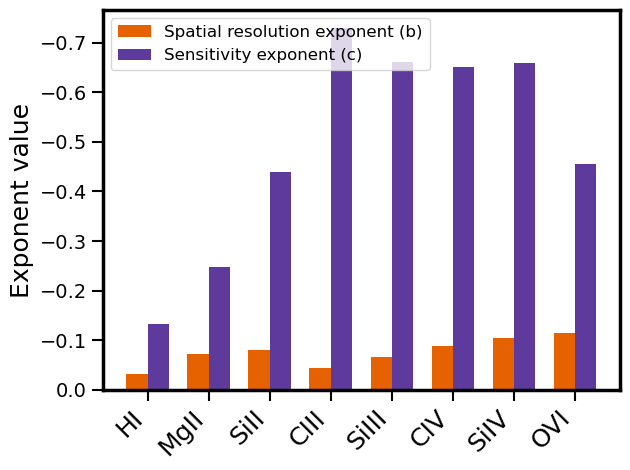

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure Ion is ordered as in your ION_LIST
ions = list(df_params['Ion'])
b_vals = df_params['b'].values
b_errs = df_params['b_err'].values
c_vals = df_params['c'].values
c_errs = df_params['c_err'].values

# ---------------- 1) Bar chart of exponents ----------------
x = np.arange(len(ions))  # positions for ions
width = 0.35              # width of bars

fig, ax = plt.subplots(figsize=(6.4,4.8))

for spine in ax.spines.values():
    spine.set_linewidth(2.5)

bars_b = ax.bar(x - width/2, b_vals, width, 
                label='Spatial resolution exponent (b)', capsize=4, color='#E66100', alpha=1)#yerr=b_errs,
bars_c = ax.bar(x + width/2, c_vals, width, 
                label='Sensitivity exponent (c)', capsize=4, color='#5D3A9B', alpha=1)#yerr=c_errs,
ax.invert_yaxis()
# Increase y-axis tick label font size
ax.tick_params(axis='y', labelsize=14)  # font size for tick labels

# Increase tick mark length and width (both x and y axes)
ax.tick_params(axis='both', which='major', length=8, width=1.5)  # major ticks
ax.tick_params(axis='both', which='minor', length=4, width=1.5)  # minor ticks if you use them

ax.axhline(0, color='k', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(ions, rotation=45, ha='right', fontsize=18)
ax.set_ylabel("Exponent value", fontsize=18)
#ax.set_title("Scaling exponents per ion")
ax.legend(fontsize=12, loc='upper left')#, bbox_to_anchor=(0.0, 1.21))
plt.tight_layout()
output_path = output_dir + '/All_halos/fitfunction_heatmaps'
os.makedirs(output_path, exist_ok=True)
output_file = os.path.join(output_path, f'fitfunction_{orientation}_{snap}.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()
plt.close()



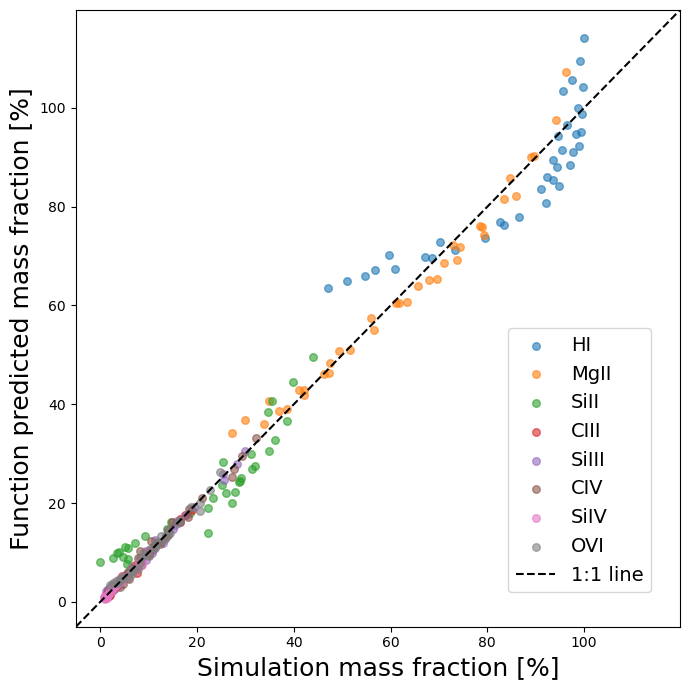

In [190]:
import matplotlib.pyplot as plt
import numpy as np

# --- Predicted vs Actual scatter for all ions ---
fig, ax = plt.subplots(figsize=(7,7))

colors = plt.cm.tab10.colors  # 10 distinct colors
for i, row in df_params.iterrows():
    ion = row['Ion']
    a, b, c = row['a'], row['b'], row['c']
    
    # Get observed grid for this ion
    xs, ys, Z = compute_mass_fraction_grid(ion, FIT_REGION, FIT_ORIENTATION)
    XX, YY = np.meshgrid(xs, ys)
    z_obs = Z.ravel()
    
    # Predicted values from fitted model
    z_pred = a * (XX.ravel()**b) * (YY.ravel()**c)
    
    # Mask NaNs/infs
    mask = np.isfinite(z_obs) & np.isfinite(z_pred)
    z_obs, z_pred = z_obs[mask], z_pred[mask]
    
    # Plot
    ax.scatter(z_obs, z_pred, s=30, alpha=0.6, label=ion,
               color=colors[i % len(colors)])

# 1:1 reference line
lims = [
    builtins.min(ax.get_xlim()[0], ax.get_ylim()[0]),
    builtins.max(ax.get_xlim()[1], ax.get_ylim()[1])
]
ax.plot(lims, lims, 'k--', lw=1.5, label="1:1 line")

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel("Simulation mass fraction [%]", fontsize=18)
ax.set_ylabel("Function predicted mass fraction [%]", fontsize=18)
#ax.set_title(f"Predicted vs. Observed Mass Fraction\n({FIT_REGION}, {FIT_ORIENTATION})")
ax.legend(bbox_to_anchor=(0.7,0.5), loc='upper left',fontsize=14)
plt.tight_layout()
plt.show()


Figure 5

region: all orientation: face


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_99605/1031101010.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.07, 0.05, 0.9, 0.95])  # Leave room on left for y-label and right for colorbar


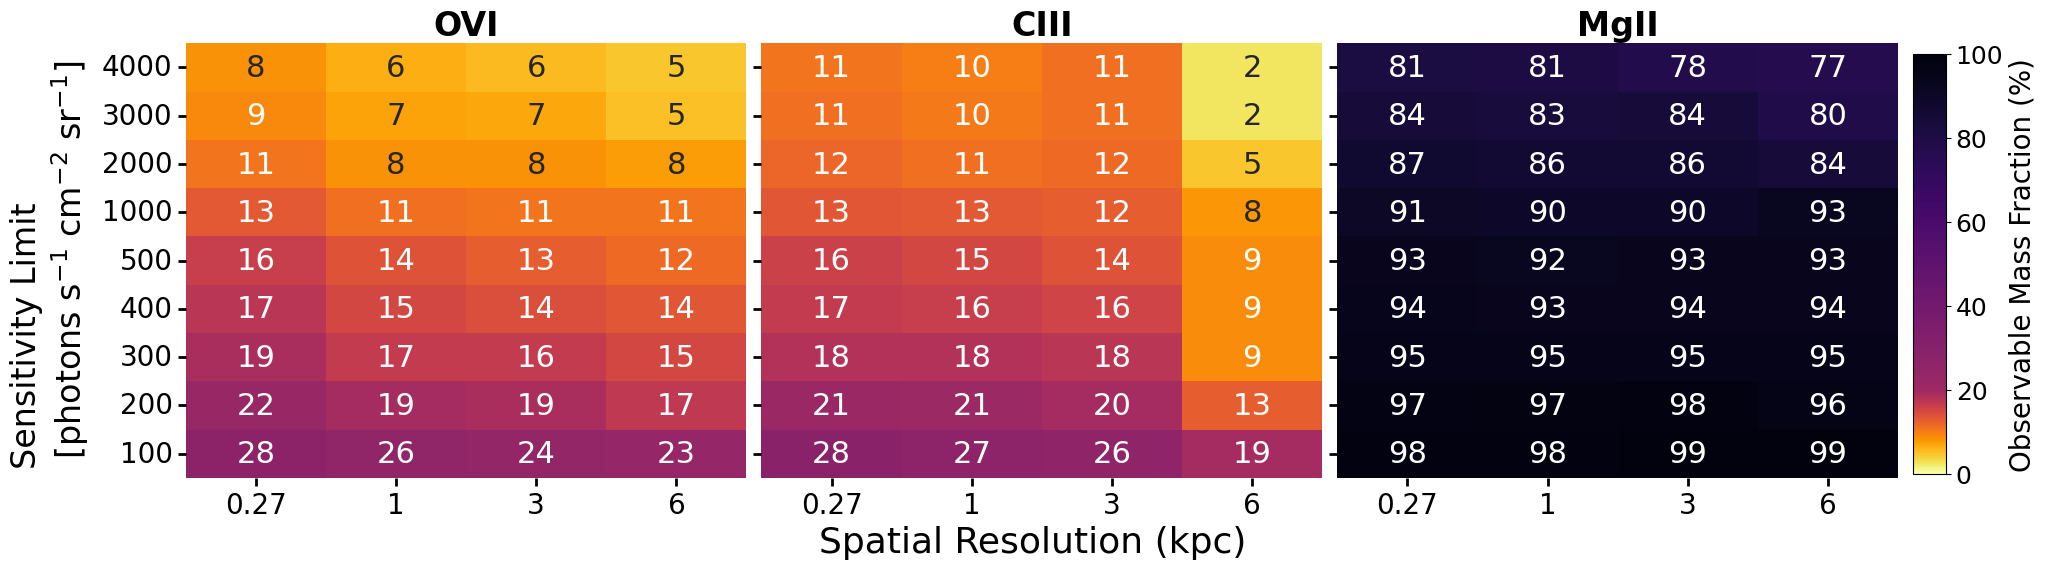

region: all orientation: edge


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_99605/1031101010.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.07, 0.05, 0.9, 0.95])  # Leave room on left for y-label and right for colorbar


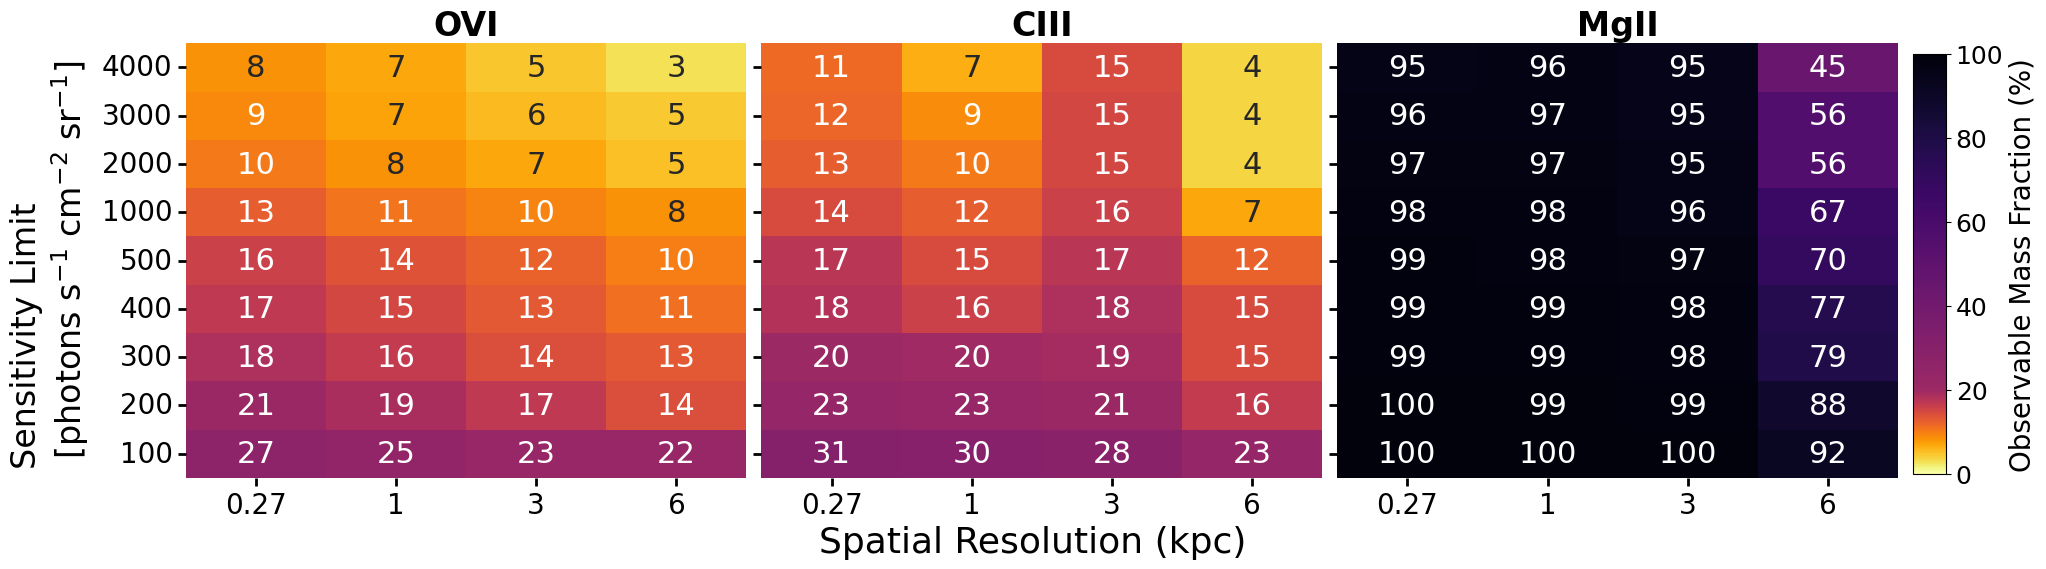

region: cgm orientation: face


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_99605/1031101010.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.07, 0.05, 0.9, 0.95])  # Leave room on left for y-label and right for colorbar


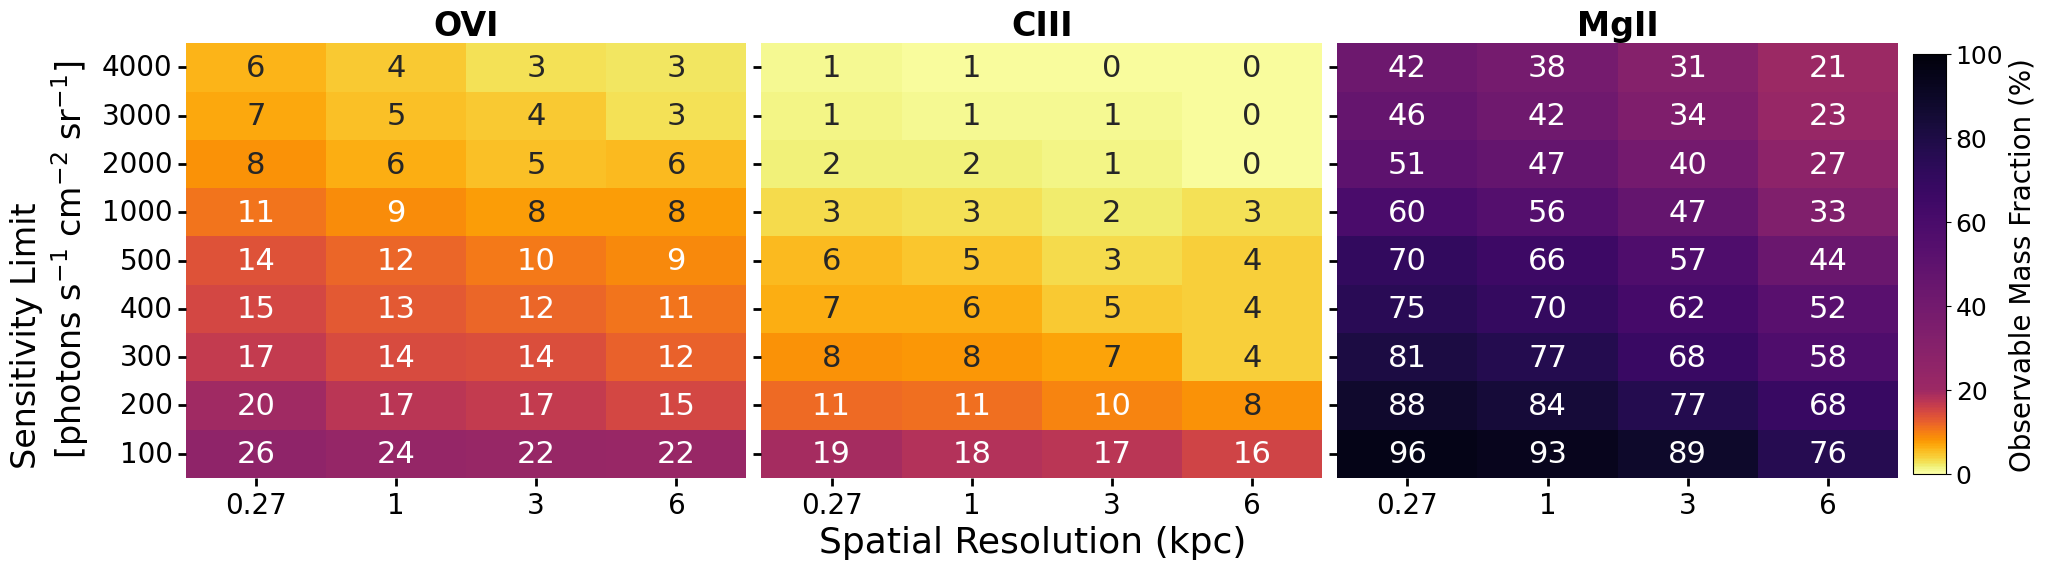

region: cgm orientation: edge


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_99605/1031101010.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.07, 0.05, 0.9, 0.95])  # Leave room on left for y-label and right for colorbar


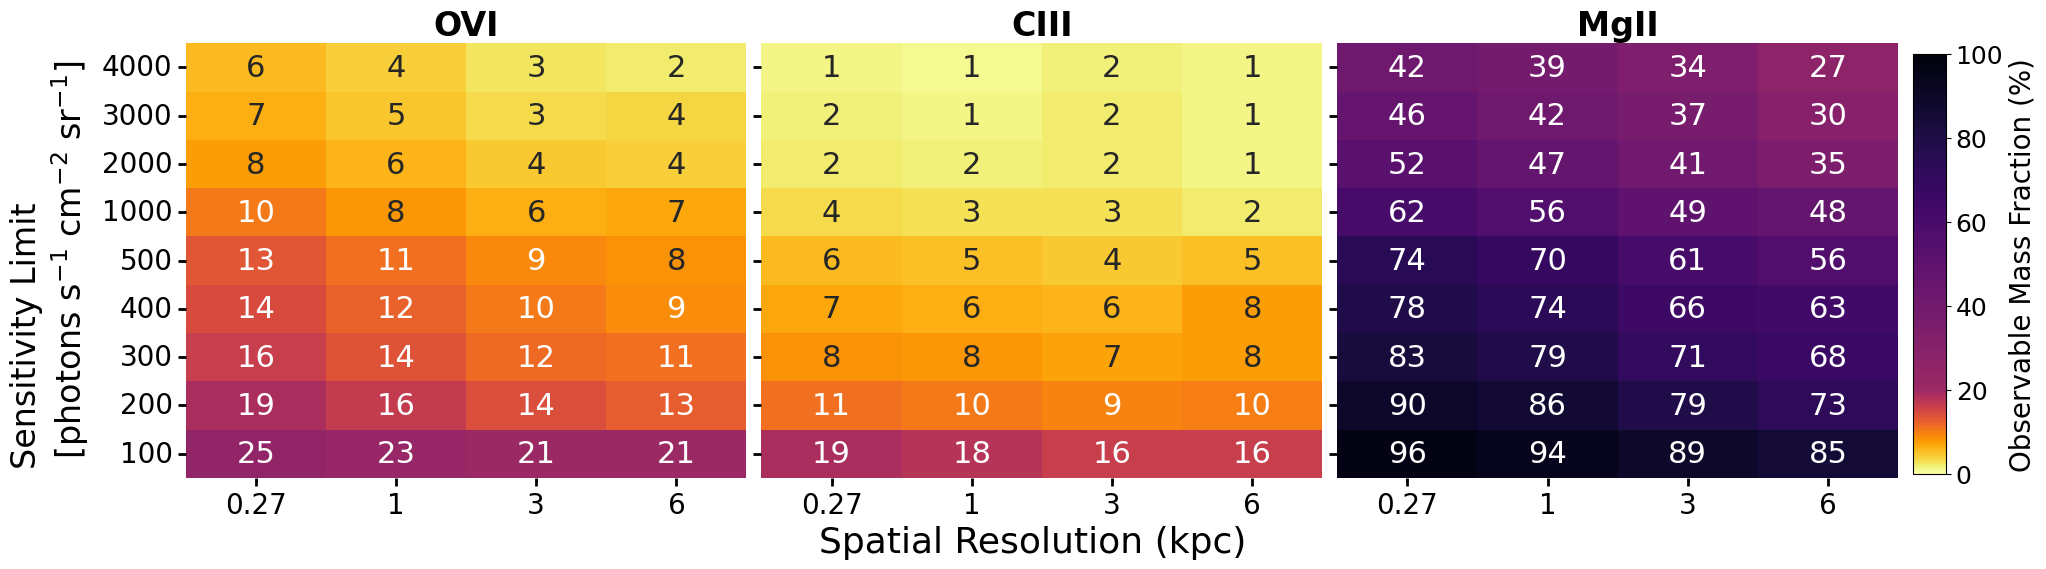

In [67]:
#####################################  Figure 5: mass fraction heat maps for all ions and spatial and spectral resolutions ###################################
ions = ['OVI', 'CIII', 'MgII']
def stretch_colormap(cmap, mid_value=0.2, mid_compress=0.5):
    """Create a new colormap that stretches colors near the low end."""
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    N = 256  # resolution of the colormap

    # Stretching function
    below = 0.58#0.7
    above = 0.4#0.4
    def scale(x):
        if x < mid_value:
            return below * (x / mid_value)  # Stretch 0–mid_value into 0–0.5
        else:
            return below + above * ((x - mid_value) / (1 - mid_value))  # Compress mid_value–1 into 0.5–1

    # Build new color mapping
    for i in range(N):
        old_idx = i / (N-1)
        new_idx = scale(old_idx)
        r, g, b, a = cmap(new_idx)
        cdict['red'].append((old_idx, r, r))
        cdict['green'].append((old_idx, g, g))
        cdict['blue'].append((old_idx, b, b))
        cdict['alpha'].append((old_idx, a, a))

    new_cmap = colors.LinearSegmentedColormap('stretched_cmap', cdict)
    return new_cmap



# Create a single color scale
vmin = 0
vmax = 100
cmap = cmr.get_sub_cmap('inferno_r', 0.0, 1)
stretched_cmap = stretch_colormap(cmap, mid_value=0.2)


for region in regions:
    
    for orientation in orientations:
        print('region:', region, 'orientation:', orientation)
        fig, axs = plt.subplots(1, 3, figsize=(22, 6), sharex=True, sharey=True)
        axs = axs.flatten()
        all_heatmaps = []
        for ion_idx, ion in enumerate(ions):
            ax = axs[ion_idx]
            heatmap_array = np.zeros((len(flux_thresholds[ion]), len(resolutions)))

            for res_idx, resolution in enumerate(resolutions):
                all_fractions_per_thresh = []

                for halo in halos:
                    halo_name = halo_dict[halo]
                    foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)

                    if region == 'all':
                        prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'with_disk', str(resolution))
                    elif region == 'cgm':
                        prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm')

                    save_path = os.path.join(prefix, 'FRBs')
                    file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

                    with h5py.File(file_path, 'r') as f:
                        mass_data = np.array(f[f'z={z}/{ion}_mass_{orientation}_{region}']).flatten()
                        emission_data = np.array(f[f'z={z}/{ion}_emission_{orientation}_{region}']).flatten()

                    total_mass = mass_data.sum()
                    halo_fractions = []
                    for thresh in flux_thresholds[ion]:
                        above_id = np.where(emission_data >= thresh)
                        mass_above = mass_data[above_id].sum()
                        frac = (mass_above / total_mass) * 100
                        halo_fractions.append(frac)

                    all_fractions_per_thresh.append(halo_fractions)

                # Compute mean across halos, store in column for that resolution
                mean_fractions = np.mean(all_fractions_per_thresh, axis=0)
                for t_idx, frac in enumerate(mean_fractions):
                    heatmap_array[t_idx, res_idx] = frac

            # Flip and annotate
            flipped_array = np.flipud(heatmap_array)
            annotations = np.round(flipped_array, 1)

            # Save for shared colorbar setup
            im = sns.heatmap(
                flipped_array,
                annot=annotations,
                fmt=".0f",
                annot_kws={"size": 22},
                ax=ax,
                xticklabels=resolutions,
                yticklabels=flux_thresholds[ion][::-1],
                vmin=vmin,
                vmax=vmax,
                cmap=stretched_cmap,
                cbar=False  # Disable individual colorbars
                #norm=norm
            )

            # if ion_idx == 0 or ion_idx == 4:
            #     ax.set_ylabel('Sensityvity limit [photons s$^{-1}$ cm$^{-2}$ sr$^{-1}$]', fontsize=15)
            # else:
            #     ax.set_ylabel('')

            # Set x-labels only on the bottom row (row 1, i.e., ion_idx >= 4)
            # if ion_idx >= 4:
            #     ax.set_xlabel('Spatial Resolution (kpc)', fontsize=15)
            # else:
            #     ax.set_xlabel('')
            if ion == 'HI':
                ax.set_title(r'H$\alpha$', fontsize=16, fontweight='bold')
            else:
                ax.set_title(ion, fontsize=24, fontweight='bold')
            ax.tick_params(axis='both', labelsize=20, length=6, width=2)
            ax.tick_params(axis='y', labelrotation=0)


            all_heatmaps.append(im)

        # Shared colorbar (based on last heatmap object)
        cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
        cbar = fig.colorbar(all_heatmaps[-1].collections[0], cax=cbar_ax)
        cbar.set_label('Observable Mass Fraction (%)', fontsize=20)
        cbar.ax.tick_params(labelsize=18)

        # Final layout
        # Adjust layout before adding shared labels
        plt.tight_layout(rect=[0.07, 0.05, 0.9, 0.95])  # Leave room on left for y-label and right for colorbar

        # Shared x and y labels
        fig.text(0.5, 0.02, 'Spatial Resolution (kpc)', ha='center', fontsize=26)
        fig.text(0.035, 0.5, 'Sensitivity Limit''\n [photons s$^{-1}$ cm$^{-2}$ sr$^{-1}$]', va='center', rotation='vertical', fontsize=24)

        output_path = output_dir + '/All_halos/Mass_fraction_heatmaps'
        os.makedirs(output_path, exist_ok=True)
        output_file = os.path.join(output_path, f'subset_{region}_allhalosave_massfraction_{orientation}_{snap}.png')
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()


Other Possible plots

/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_13595/1126836986.py:95: RuntimeWarning: All-NaN slice encountered
  median = np.nanmedian(profiles, axis=0)


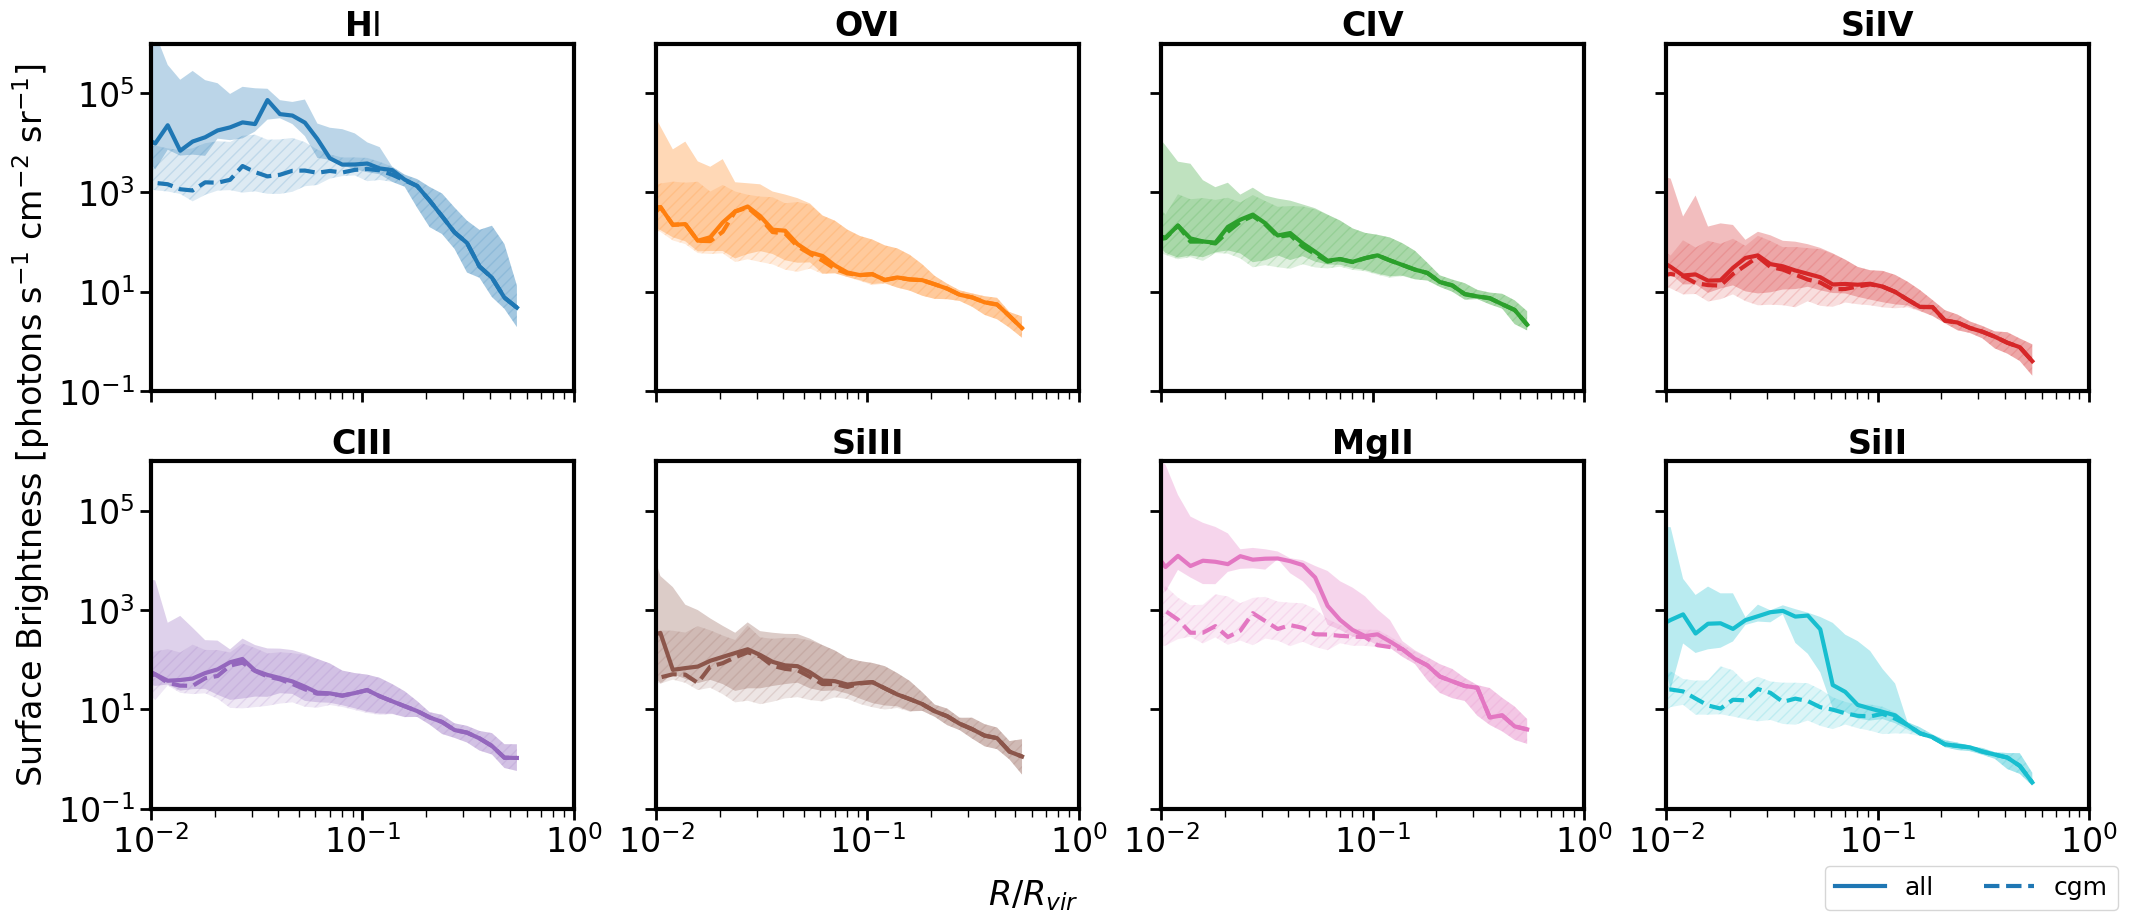

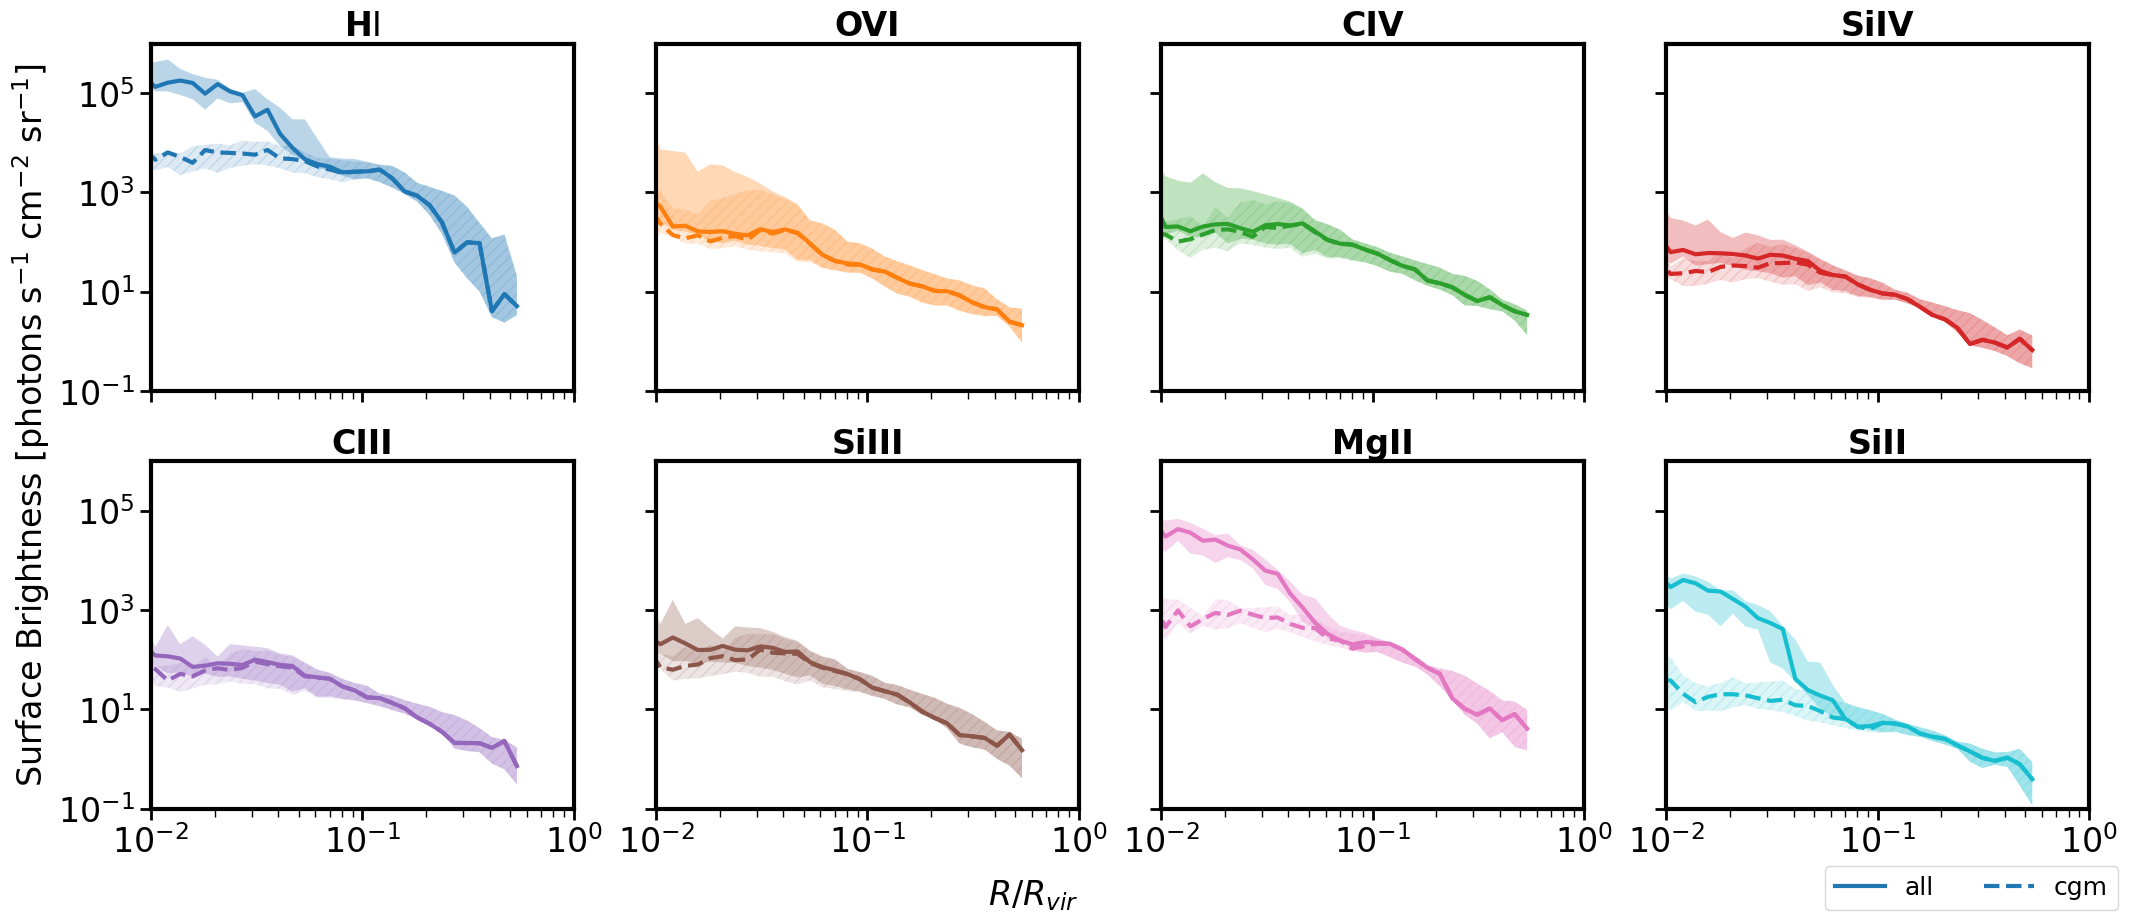

In [26]:

# Settings
ions = ['HI', 'OVI', 'CIV', 'SiIV', 'CIII', 'SiIII', 'MgII', 'SiII']
ion_color_dict = {
    'HI': '#1f77b4', 'OVI': '#ff7f0e', 'CIV': '#2ca02c', 'SiIV': '#d62728',
    'CIII': '#9467bd', 'SiIII': '#8c564b', 'MgII': '#e377c2', 'SiII': '#17becf'
}
orientations = ['face', 'edge']
halos = ['2878','2392','5016','5036','8508']
r_bins = np.logspace(np.log10(0.5), 2.0, 40)
r_centers = 0.5 * (r_bins[1:] + r_bins[:-1])
font_title = 24
font_label = 24
font_tick = 24
font_legend = 18
z = 0.5  # target redshift
resolutions = [0.27]
resolution = resolutions[0]

# Container for all profiles
all_profiles = {region: {ori: {ion: [] for ion in ions} for ori in orientations} for region in ['all', 'cgm']}

for region in ['all', 'cgm']:
    for halo in halos:
        halo_name = halo_dict[halo]
        for orientation in orientations:
            for ion in ions:
                # Get Rvir
                halo_infor_path = '/Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/' + f'/halo_infos/00{halo}/{run}' 
                rvir_masses_file = os.path.join(halo_infor_path, "rvir_masses.hdf5")
                with h5py.File(rvir_masses_file, 'r') as f:
                    data = f['all_data'][:]
                    idx = np.argmin(np.abs(data['redshift'] - z))
                    rvir = data['radius'][idx]

                if region == 'all':
                    prefix = os.path.join(
                        output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                        f'box_{box_name}', 'with_disk', str(resolution)
                    )
                else:
                    prefix = os.path.join(
                        output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output,
                        f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm'
                    )

                file_path = os.path.join(prefix, 'FRBs', f"{halo_name}_emission_maps.hdf5")
                if not os.path.exists(file_path):
                    continue

                with h5py.File(file_path, 'r') as f:
                    x = np.array(f[f'z={z}/{ion}_x_{orientation}_{region}'])
                    y = np.array(f[f'z={z}/{ion}_y_{orientation}_{region}'])
                    emission = np.array(f[f'z={z}/{ion}_emission_{orientation}_{region}']).flatten()

                xx, yy = np.meshgrid(x, y)
                radius = np.sqrt(xx**2 + yy**2).flatten()
                mask = emission > 1e-1
                radius = radius[mask]
                emission = emission[mask]

                profile = np.full(len(r_centers), np.nan)
                for i in range(len(r_centers)):
                    in_bin = (radius >= r_bins[i]) & (radius < r_bins[i+1])
                    if np.any(in_bin):
                        profile[i] = np.median(emission[in_bin])

                all_profiles[region][orientation][ion].append((profile, rvir))

# Plotting
for orientation in orientations:
    fig, axs = plt.subplots(2, 4, figsize=(22, 10), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.0001, hspace=0.01)
    axs = axs.flatten()

    for ion_idx, ion in enumerate(ions):
        ax = axs[ion_idx]
        color = ion_color_dict[ion]

        for spine in ax.spines.values():
            spine.set_linewidth(3)
            spine.set_edgecolor('black')

        for region, linestyle, hatch, alpha in [
            ('all', '-', None, 0.3),
            ('cgm', '--', '///', 0.15)
        ]:
            # Normalize profiles by Rvir
            profiles = []
            for prof, rvir in all_profiles[region][orientation][ion]:
                profiles.append(prof)  # normalize by rvir

            profiles = np.array(profiles)
            if profiles.shape[0] == 0:
                continue
            median = np.nanmedian(profiles, axis=0)
            p16 = np.nanpercentile(profiles, 16, axis=0)
            p84 = np.nanpercentile(profiles, 84, axis=0)

            ax.plot(r_centers / rvir, median, lw=3, color=color, linestyle=linestyle, label=f'{region}')
            ax.fill_between(r_centers / rvir, p16, p84, facecolor=color, alpha=alpha,
                            hatch=hatch, edgecolor=color if hatch else None, linewidth=0.0)

        ax.set_title(r'H$\mathrm{I}$' if ion == 'HI' else ion, fontsize=font_title, fontweight='bold')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(1e-2, 1)
        ax.set_ylim(1e-1, 1e6)
        ax.tick_params(labelsize=font_tick)
        ax.tick_params(labelsize=font_tick, length=8, width=2, direction='out', which='major')
        ax.tick_params(length=6, width=1, direction='out', which='minor')

    fig.text(0.5, 0.02, '$R/R_{vir}$', ha='center', fontsize=font_label)
    fig.text(0.035, 0.5, 'Surface Brightness [photons s$^{-1}$ cm$^{-2}$ sr$^{-1}$]', va='center',
             rotation='vertical', fontsize=font_label)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right', ncol=4, fontsize=font_legend)

    plt.tight_layout(rect=[0.05, 0.05, 1, 0.93])
    save_dir = os.path.join(output_dir, 'All_halos', 'emission_profiles')
    os.makedirs(save_dir, exist_ok=True)
    save_name = f"all&cgm_allhalos_{orientation}_{resolution}_median_profiles_allcgm.png"
    plt.savefig(os.path.join(save_dir, save_name), dpi=400)
    plt.show()
    plt.close()


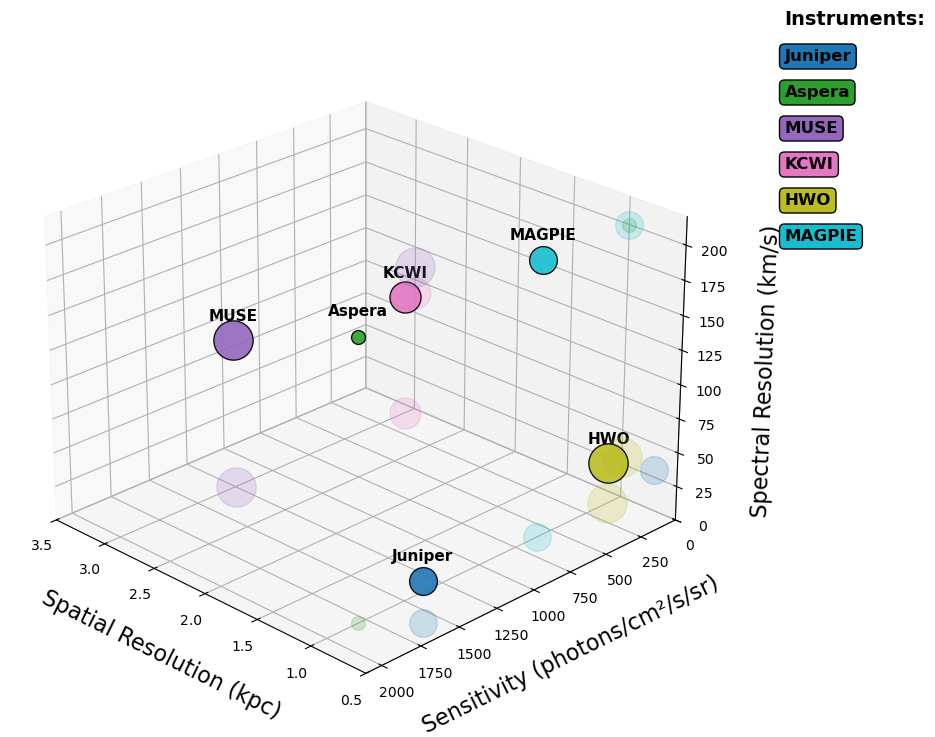

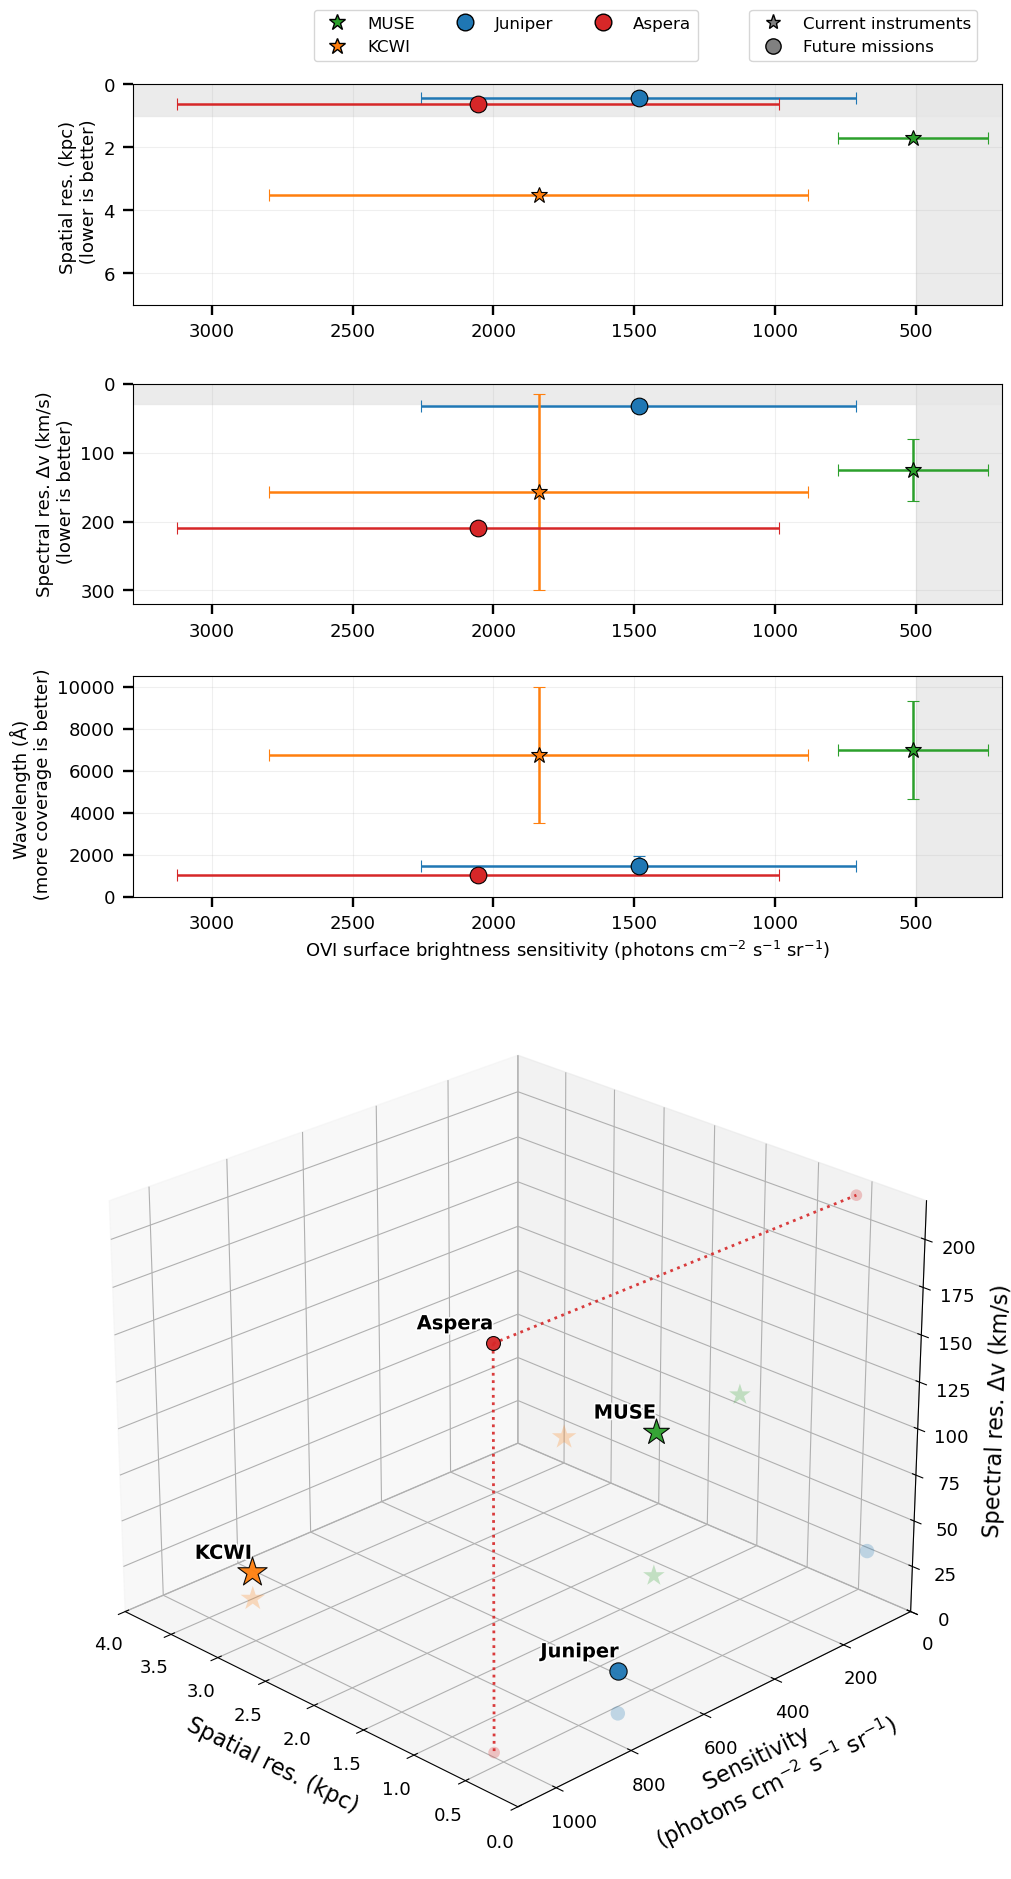

Saved: /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/Conclusion/instruments_markers_errorbars_woHWO.png


In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import os

from mpl_toolkits.mplot3d.art3d import Line3DCollection

def add_corner_wireframe(ax, x1=1.0, y1=500.0, z1=30.0, color='0.35', lw=2.0, dash=True):
    """Draw only the edges of the target region 0<=x<=x1, 0<=y<=y1, 0<=z<=z1."""
    # 12 edges of the rectangular box
    e = []
    # edges parallel to x
    e += [((0,0,0),(x1,0,0)), ((0,y1,0),(x1,y1,0)),
          ((0,0,z1),(x1,0,z1)), ((0,y1,z1),(x1,y1,z1))]
    # edges parallel to y
    e += [((0,0,0),(0,y1,0)), ((x1,0,0),(x1,y1,0)),
          ((0,0,z1),(0,y1,z1)), ((x1,0,z1),(x1,y1,z1))]
    # edges parallel to z
    e += [((0,0,0),(0,0,z1)), ((x1,0,0),(x1,0,z1)),
          ((0,y1,0),(0,y1,z1)), ((x1,y1,0),(x1,y1,z1))]

    ls = (0, (4, 3)) if dash else 'solid'
    lc = Line3DCollection(e, colors=color, linewidths=lw, linestyles=ls, alpha=0.9)
    ax.add_collection3d(lc)
    # Optional label
    #ax.text(x1*0.45, y1*0.45, z1*1.06, "Target region", color=color, fontsize=10,
    #        ha='center', va='bottom', weight='bold')


# -----------------------
# Data (from your updated table)
# -----------------------
rows = [
    
    ("Juniper", 0.43, (713, 2256),  (23, 40),     (1025, 1929)),
    ("KCWI",    3.5,  (884, 2795),  (15, 300),    (3500, 10000)),
    ("MUSE",    1.7,  (246, 778),   (80, 170),    (4650, 9300)),
    ("Aspera",  0.64, (987, 3123),  (210, 210),   (1030, 1040)),# changed the spectral re for clarity
    
]
#("HWO",     0.3, (100, 320),   (20, 20),     (1000, 10000)),# changed the spatial re for clarity
#("HARMONI",  0.26, (50, 155),  (17, 90),   (4600, 24600))# changed the spectral re for clarity
#("MaGPIE",  6.37, (428, 1354),  (190, 190),   (1000, 3000)),# changed the spectral re for clarity

df = pd.DataFrame({
    "Instrument":      [r[0] for r in rows],
    "Spatial_kpc":     [r[1] for r in rows],
    "Sensitivity_min": [r[2][0] for r in rows],   # OVI (100 hr)
    "Sensitivity_max": [r[2][1] for r in rows],   # OVI (10 hr)
    "SpecRes_min":     [r[3][0] for r in rows],   # Δv (km/s)
    "SpecRes_max":     [r[3][1] for r in rows],
    "Wav_min":         [r[4][0] for r in rows],   # Å
    "Wav_max":         [r[4][1] for r in rows],
})

# label_offsets = {
#     # (dx in kpc, dy in sensitivity units, dz in km/s, ha, va)
#     "HWO":      ( 0.2,  110, 0, 'left',  'bottom'),"HARMONI":  ( -0.12,  -45,  12, 'right', 'bottom'),
#     # tweak others here if needed
# }
label_offsets = {
    # (dx in kpc, dy in sensitivity units, dz in km/s, ha, va)
    "HWO":      ( 0.2,  175, 0, 'left',  'bottom')
    # tweak others here if needed
}

def mid_min_max(lo, hi):
    lo, hi = float(lo), float(hi)
    return 0.5*(lo+hi), lo, hi

def sens_mid_err(row):
    xm, lo, hi = mid_min_max(row["Sensitivity_min"], row["Sensitivity_max"])
    return xm, np.array([[xm - lo], [hi - xm]])

def spec_mid_err(row):
    ym, lo, hi = mid_min_max(row["SpecRes_min"], row["SpecRes_max"])
    return ym, np.array([[ym - lo], [hi - ym]])

def wav_mid_err(row):
    ym, lo, hi = mid_min_max(row["Wav_min"], row["Wav_max"])
    return ym, np.array([[ym - lo], [hi - ym]])

# -----------------------
# Styling
# -----------------------
current = {"MUSE", "KCWI"}  # current missions
palette = plt.cm.tab10(np.linspace(0, 1, max(10, len(df))))
instr2color = {inst: palette[i % len(palette)] for i, inst in enumerate(df["Instrument"])}

def shape_for(inst):
    return '*' if inst in current else 'o'

# -----------------------
# Figure (3 stacked 2D + 1 wide 3D)
# -----------------------
plt.close('all')
fig = plt.figure(figsize=(10, 18), constrained_layout=True)

gs = fig.add_gridspec(2, 1, height_ratios=[2, 2])

gs_top = gs[0].subgridspec(3, 1, hspace=0.06)
axA = fig.add_subplot(gs_top[0, 0])             # Spatial vs Sensitivity
axB = fig.add_subplot(gs_top[1, 0], sharex=axA) # Spectral vs Sensitivity
axC = fig.add_subplot(gs_top[2, 0], sharex=axA) # Wavelength vs Sensitivity
axD = fig.add_subplot(gs[1], projection='3d')   # 3D

# -----------------------
# X limits (sensitivity) and shading thresholds
# -----------------------
XMIN = float(builtins.min(df["Sensitivity_min"].min(), df["Sensitivity_max"].min()) * 0.8)
XMAX = float(builtins.max(df["Sensitivity_min"].max(), df["Sensitivity_max"].max()) * 1.05)
SHADE = dict(color='0.9', alpha=0.8, zorder=0)

# --- Panel A
axA.set_ylabel("Spatial res. (kpc) \n (lower is better)", fontsize=13)
axA.set_xlim(XMIN, XMAX); axA.invert_xaxis()
axA.set_ylim(0, max(7.0, float(df["Spatial_kpc"].max()) + 0.5)); axA.invert_yaxis()
axA.grid(True, alpha=0.2)
axA.axvspan(XMIN, 500, **SHADE)  # sensitivity < 500
axA.axhspan(0, 1, **SHADE)       # spatial < 1 kpc
for _, r in df.iterrows():
    inst, col, m = r["Instrument"], instr2color[r["Instrument"]], shape_for(r["Instrument"])
    xmid, xerr = sens_mid_err(r)
    ymid = float(r["Spatial_kpc"])
    axA.errorbar(xmid, ymid, xerr=xerr, yerr=None, fmt=m, ms=12, color=col, ecolor=col,
                 elinewidth=1.8, capsize=4, mec='k', mew=0.8)

# --- Panel B
axB.set_ylabel("Spectral res. Δv (km/s)\n (lower is better)", fontsize=13)
axB.set_xlim(XMIN, XMAX); axB.invert_xaxis()
axB.set_ylim(0, max(320.0, float(df["SpecRes_max"].max()) * 1.05)); axB.invert_yaxis()
axB.grid(True, alpha=0.2)
axB.axvspan(XMIN, 500, **SHADE)  # sensitivity < 500
axB.axhspan(0, 30, **SHADE)      # Δv ≤ 30
for _, r in df.iterrows():
    inst, col, m = r["Instrument"], instr2color[r["Instrument"]], shape_for(r["Instrument"])
    xmid, xerr = sens_mid_err(r)
    ymid, yerr = spec_mid_err(r)
    axB.errorbar(xmid, ymid, xerr=xerr, yerr=yerr, fmt=m, ms=12, color=col, ecolor=col,
                 elinewidth=1.8, capsize=4, mec='k', mew=0.8)

# --- Panel C
axC.set_xlabel("OVI surface brightness sensitivity (photons cm$^{-2}$ s$^{-1}$ sr$^{-1}$)", fontsize=13)
axC.set_ylabel("Wavelength (Å) \n (more coverage is better)", fontsize=13)
axC.set_xlim(XMIN, XMAX); axC.invert_xaxis()
axC.set_ylim(0, float(df["Wav_max"].max()) * 1.05)
axC.grid(True, alpha=0.2)
axC.axvspan(XMIN, 500, **SHADE)  # sensitivity < 500
for _, r in df.iterrows():
    inst, col, m = r["Instrument"], instr2color[r["Instrument"]], shape_for(r["Instrument"])
    xmid, xerr = sens_mid_err(r)
    ymid, yerr = wav_mid_err(r)
    axC.errorbar(xmid, ymid, xerr=xerr, yerr=yerr, fmt=m, ms=12, color=col, ecolor=col,
                 elinewidth=1.8, capsize=4, mec='k', mew=0.8)

# -----------------------
# Panel D: 3D scatter (no error bars) + gray box + wall shadows
# -----------------------
axD.set_xlabel("Spatial res. (kpc)", fontsize=16, labelpad=12)
axD.set_ylabel("Sensitivity \n (photons cm$^{-2}$ s$^{-1}$ sr$^{-1}$)", fontsize=16, labelpad=16)
axD.set_zlabel("Spectral res. Δv (km/s)", fontsize=16, labelpad=12)

xmax3d = max(7.0, float(df["Spatial_kpc"].max()) * 1.05)
ymax3d = XMAX
zmax3d = max(320.0, float(df["SpecRes_max"].max()) * 1.05)
axD.set_xlim(0, 4)#xmax3d)
axD.set_ylim(0, 1100)
axD.set_zlim(0, 220)
axD.view_init(elev=25, azim=135)
try:
    axD.set_box_aspect((1,1,0.8))
except Exception:
    pass


# --- Highlight "best" corner cleanly (wireframe only)
# add_corner_wireframe(axD, x1=1.0, y1=500.0, z1=30.0, color='0.35', lw=2.0, dash=True)

# --- Scatter points + wall shadows
for _, r in df.iterrows():
    inst = r["Instrument"]; col = instr2color[inst]; m = shape_for(inst)
    x = float(r["Spatial_kpc"])                # spatial (single value)
    y = float(r["Sensitivity_min"])            # best sensitivity (100 hr)
    z = float(r["SpecRes_min"])                # best Δv
    wav_span = 3 * float(r["Wav_max"] - r["Wav_min"])
    size = 100 + 0.02 * wav_span

    # Main point
    axD.scatter(x, y, z, s=size, c=[col], marker=m, edgecolor='k', linewidths=0.8, alpha=0.95)
    #axD.text(x, y, z + 16, inst, fontsize=10, ha='center', va='bottom', weight='bold')

    # --- label with per-instrument offset + leader line
    dx, dy, dz, ha, va = label_offsets.get(inst, (0.0, 0.0, 5.0, 'right', 'bottom'))
    xt, yt, zt = x + dx, y + dy, z + dz

    # text with a light stroke for readability
    import matplotlib.patheffects as pe
    axD.text(
        xt, yt, zt, inst, fontsize=14, ha=ha, va=va, weight='bold',
        path_effects=[pe.withStroke(linewidth=2.5, foreground='white', alpha=0.9)]
    )

    # Shadows (mirrors):
    sh_alpha = 0.25
    sh_ec = 'none'
    # 1) Spatial × Sensitivity plane (xy): z=0
    axD.scatter(x, y, 0, s=size*0.7, c=[col], marker=m, alpha=sh_alpha, edgecolor=sh_ec)
    # 2) Sensitivity × Spectral plane (yz): x=0
    axD.scatter(x, 0, z, s=size*0.7, c=[col], marker=m, alpha=sh_alpha, edgecolor=sh_ec)

    if inst == "Aspera":
        # to z=0 plane (xy)
        axD.plot([x, x], [y, y], [z, 0],
                linestyle=':', color=col, lw=2, alpha=0.9, zorder=10)
        # to x=0 plane (yz)
        axD.plot([x, x], [y, 0], [z, z],
                linestyle=':', color=col, lw=2, alpha=0.9, zorder=10)
        
#---------------- axis tick sizes
# 2D axes
for ax in (axA, axB, axC):
    ax.tick_params(axis='both', which='both',
                   labelsize=13, length=7, width=1.7, pad=6)

# 3D axis (do x, y, and z explicitly)
axD.tick_params(axis='x', which='both',
                labelsize=13, length=7, width=2, pad=6)
axD.tick_params(axis='y', which='both',
                labelsize=13, length=7, width=2, pad=6)
axD.tick_params(axis='z', which='both',
                labelsize=13, length=7, width=2, pad=6)

# -----------------------
# Legends
# -----------------------
# Instruments legend: first the two current missions (stars), then the rest (circles)
order = ["MUSE", "KCWI"] + [inst for inst in df["Instrument"] if inst not in {"MUSE", "KCWI"}]
instr_handles = []
for inst in order:
    marker = '*' if inst in current else 'o'
    instr_handles.append(Line2D([0],[0], marker=marker, color='w', label=inst,
                                markerfacecolor=instr2color[inst], markeredgecolor='k', markersize=12))

# Status legend (shape-only explanation)
status_handles = [
    Line2D([0],[0], marker='*', color='w', label='Current instruments',
           markerfacecolor='gray', markeredgecolor='k', markersize=11),
    Line2D([0],[0], marker='o', color='w', label='Future missions',
           markerfacecolor='gray', markeredgecolor='k', markersize=11),
]

# Place legends
fig.legend(handles=instr_handles, loc='upper center',
           bbox_to_anchor=(0.5, 1.04), ncol=3, frameon=True, fontsize=12)
fig.legend(handles=status_handles, loc='upper right',
           bbox_to_anchor=(0.98, 1.04), frameon=True, fontsize=12)

# -----------------------
# Save
# -----------------------
output_path = '/Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/Conclusion/'
os.makedirs(output_path, exist_ok=True)
out_file = os.path.join(output_path, 'instruments_markers_errorbars_woHWO.png')
plt.savefig(out_file, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
print(f"Saved: {out_file}")


In [4]:
# converting spatial resolution from arcsec to kpc

from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import numpy as np

def spatial_resolution(theta_arcsec, z):
    """
    Convert angular resolution (arcsec) at redshift z
    into physical scale (kpc).
    
    Parameters
    ----------
    theta_arcsec : float
        Angular resolution in arcseconds.
    z : float
        Target redshift.
    
    Returns
    -------
    float
        Physical resolution in kpc.
    """
    # Angular diameter distance in kpc
    DA = cosmo.angular_diameter_distance(z).to(u.kpc).value
    
    # Convert arcsec to radians
    theta_rad = theta_arcsec * (np.pi / 648000.0)
    
    # Physical size in kpc
    return theta_rad * DA




In [18]:

print(np.round(spatial_resolution(0.03, 2), 2),"kpc")

0.26 kpc


In [6]:
def velocity_to_R(delta_v_kms):
    """
    Convert spectral resolution from velocity units (km/s) 
    to resolving power R.
    
    Parameters
    ----------
    delta_v_kms : float or list of floats
        Spectral resolution in km/s.
        
    Returns
    -------
    float or list of floats
        Resolving power R.
    """
    c = 299792.458  # speed of light in km/s
    if isinstance(delta_v_kms, (list, tuple)):
        return [c / dv for dv in delta_v_kms]
    else:
        return c / delta_v_kms




In [29]:
# Examples
print(np.round(velocity_to_R(90),0))


3331.0


In [8]:
import numpy as np

def sb_to_photons(sb_erg, wavelength_A):
    """
    Convert surface brightness from erg/s/cm^2/arcsec^2 
    to photons/s/cm^2/sr at a given wavelength.
    
    Parameters
    ----------
    sb_erg : float
        Surface brightness in erg/s/cm^2/arcsec^2
    wavelength_A : float
        Wavelength in Angstroms (Å)
        
    Returns
    -------
    float
        Photon surface brightness in photons/s/cm^2/sr
    """
    # constants
    h = 6.62607015e-27  # erg*s
    c = 2.99792458e10   # cm/s
    
    # energy per photon
    wavelength_cm = wavelength_A * 1e-8
    E_photon = h * c / wavelength_cm
    
    # convert arcsec^2 -> sr
    arcsec2_to_sr = (np.pi / (180.0 * 3600.0))**2
    
    # convert SB to erg/s/cm^2/sr
    sb_erg_sr = sb_erg / arcsec2_to_sr
    
    # photons
    photons = sb_erg_sr / E_photon
    return photons





In [9]:
# Example: MAGPIE, OVI 1032 Å, SB = 3e-19 erg/s/cm^2/arcsec^2
sb_limit = 1e-19
wavelength = 1032.0  # Å
print(sb_to_photons(sb_limit, wavelength), "photons cm^-2 s^-1 sr^-1")

221.03102174980287 photons cm^-2 s^-1 sr^-1


In [10]:
import numpy as np

# --- Constants ---
H = 6.62607015e-27       # Planck constant [erg*s]
C = 2.99792458e10        # speed of light [cm/s]
ARCSEC2_TO_SR = (np.pi / (180.0 * 3600.0))**2  # 1 arcsec^2 in steradians


def sb_scale(sb_ref, t_ref_hr, t_new_hr):
    """
    Scale a surface-brightness (SB) limit between exposure times assuming background-limited regime:
        SB_new = SB_ref * sqrt(t_ref / t_new)

    Parameters
    ----------
    sb_ref : float
        Reference SB limit in erg/s/cm^2/arcsec^2.
    t_ref_hr : float
        Reference exposure time in hours.
    t_new_hr : float or array-like
        New exposure time(s) in hours.

    Returns
    -------
    float or np.ndarray
        Scaled SB limit(s) in erg/s/cm^2/arcsec^2.
    """
    t_new_hr = np.asarray(t_new_hr, dtype=float)
    return sb_ref * np.sqrt(t_ref_hr / t_new_hr)


def sb_erg_arcsec2_to_photons_sr(sb_erg_arcsec2, wavelength_A):
    """
    Convert SB from erg/s/cm^2/arcsec^2 to photons/s/cm^2/sr at a given wavelength.

    Parameters
    ----------
    sb_erg_arcsec2 : float or array-like
        SB in erg/s/cm^2/arcsec^2.
    wavelength_A : float
        Wavelength in Angstroms (Å).

    Returns
    -------
    float or np.ndarray
        Photon SB in photons/s/cm^2/sr.
    """
    wavelength_cm = wavelength_A * 1e-8
    E_photon = H * C / wavelength_cm  # [erg]
    sb_erg_sr = np.asarray(sb_erg_arcsec2, dtype=float) / ARCSEC2_TO_SR
    return sb_erg_sr / E_photon


def convert_sb(sb_ref_erg_arcsec2, t_ref_hr, t_list_hr, wavelength_A):
    """
    Convenience wrapper: scale an SB limit from a reference exposure to a list of new exposures
    and convert each to photons/s/cm^2/sr at the given wavelength.

    Returns a dict with both erg and photon units.
    """
    t_list_hr = np.atleast_1d(t_list_hr).astype(float)
    sb_scaled_erg = sb_scale(sb_ref_erg_arcsec2, t_ref_hr, t_list_hr)
    sb_scaled_phot = sb_erg_arcsec2_to_photons_sr(sb_scaled_erg, wavelength_A)
    return {
        "exposures_hr": t_list_hr,
        "sb_erg_arcsec2": sb_scaled_erg,
        "sb_photons_sr": sb_scaled_phot,
    }




In [11]:
# ---- Example: MAGPIE, O VI 1032 Å ----
# Given: SB_ref = 3e-19 erg/s/cm^2/arcsec^2 at t_ref = 41.7 hr
example = convert_sb(
    sb_ref_erg_arcsec2=1e-19,
    t_ref_hr=5,
    t_list_hr=[10, 100],
    wavelength_A=1032.0
)

for t, sb_erg, sb_ph in zip(example["exposures_hr"], example["sb_erg_arcsec2"], example["sb_photons_sr"]):
    print(f"Exposure = {t:6.1f} hr | SB = {sb_erg:.3e} erg/s/cm^2/arcsec^2 | "
          f"{sb_ph:7.1f} photons/s/cm^2/sr (OVI 1032 Å)")

Exposure =   10.0 hr | SB = 7.071e-20 erg/s/cm^2/arcsec^2 |   156.3 photons/s/cm^2/sr (OVI 1032 Å)
Exposure =  100.0 hr | SB = 2.236e-20 erg/s/cm^2/arcsec^2 |    49.4 photons/s/cm^2/sr (OVI 1032 Å)
